In [12]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Table of Content
- [1. Time Series Modelling](#Time-Series-Modelling)
- [2. Read Data and Compute GDP Rate](#Read-Data-and-Compute-GDP-Rate)
- [3. Load News Articles collected from NewYork Times](#Load-News-Articles-collected-from-NewYork-Times)
- [4. Calculate Sentiment scores for each quarter](#Calculate-Sentiment-scores-for-each-quarter)
- [5. Read Sentiment scores as predictors](#Read-Sentiment-scores-as-predictors)
- [6. Basic Time Series Model](#Basic-Time-Series-Model)
- [7. Mean Model](#Mean-Model)
- [8. Linear Trend Model](#Linear-Trend-Model)
- [9. Linear Model with Regressor](#Linear-Model-with-Regressor)
- [10. Baseline Model - Random Walk](#Baseline-Model:-Random-Walk)
- [11. Simple Exponential Smoothing Model](#Simple-Exponential-Smoothing-Model)
- [12. Eliminating Trend and Seasonality](#Eliminating-Trend-and-Seasonality)
- [13. Time Series Differencing](#Time-Series-Differencing)
- [14. Time Series Decomposition](#Time-Series-Decomposition)
- [15. Auto Regressive Models](#Auto-Regressive-Models)
- [16. Moving Average Models](#Moving-Average-Models)
- [17. ARIMA Models](#ARIMA-Models)
- [18. Prediction using Model](#Prediction-using-Model])



# Time Series Modelling

In [22]:
import sys, os
import numpy as np
import pylab as pl
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import sklearn as sk
import sklearn.discriminant_analysis as da
import sklearn.neighbors as knn
from datetime import  datetime, timedelta
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import pos_tag
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
#import nltk
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.stem.porter import PorterStemmer


import nltk
import re
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
from nltk.wsd import lesk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer

import sqlite3 as sqlite

import warnings
warnings.filterwarnings('ignore')

import re
%matplotlib inline

In [44]:
# Set parameters to set the default size of ggplots to 15,10
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 10)

## Read Data and Compute GDP Rate

In [15]:
#Show snapshot of available GDP data
gdp_data = pd.read_csv('../data/gdp.csv', sep = '\t')
gdp_data.head()

,quarter,gdp_current,gdp_chained
0,1947q1,243.1,1934.5
1,1947q2,246.3,1932.3
2,1947q3,250.1,1930.3
3,1947q4,260.3,1960.7
4,1948q1,266.2,1989.5


In [16]:
#define quarters based on dates per year
def quarter_to_date(quarter):
    year = quarter[:-2]
    q = quarter[-2:]
    if q == 'q1':
        return (datetime(year=int(year), month=1, day=1).date(), 
                datetime(year=int(year), month=3, day=31).date())
    elif q == 'q2':
        return (datetime(year=int(year), month=4, day=1).date(),
                datetime(year=int(year), month=6, day=30).date())
    elif q == 'q3':
        return (datetime(year=int(year), month=7, day=1).date(), 
                datetime(year=int(year), month=9, day=30).date())
    elif q == 'q4':
        return (datetime(year=int(year), month=10, day=1).date(), 
                datetime(year=int(year), month=12, day=31).date())

In [17]:
gdp_data['start_date'] = gdp_data['quarter'].apply(lambda x: quarter_to_date(x)[0])
gdp_data['end_date'] = gdp_data['quarter'].apply(lambda x: quarter_to_date(x)[0])
gdp_data.head()

,quarter,gdp_current,gdp_chained,start_date,end_date
0,1947q1,243.1,1934.5,1947-01-01,1947-01-01
1,1947q2,246.3,1932.3,1947-04-01,1947-04-01
2,1947q3,250.1,1930.3,1947-07-01,1947-07-01
3,1947q4,260.3,1960.7,1947-10-01,1947-10-01
4,1948q1,266.2,1989.5,1948-01-01,1948-01-01


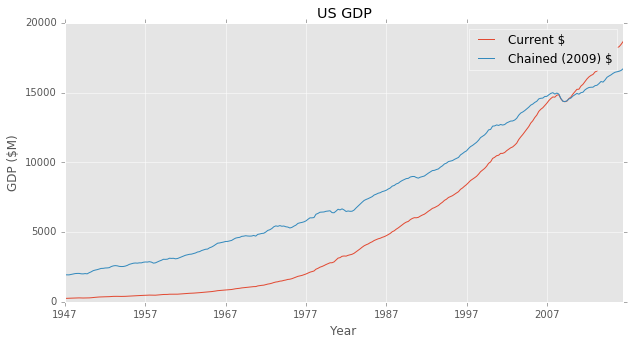

In [18]:
#plot GDP trend
plt.figure(figsize=(10,5))
plt.title('US GDP')
plt.plot(gdp_data['end_date'], gdp_data[[1]], label='Current $')
plt.plot(gdp_data['end_date'], gdp_data[[2]], label='Chained (2009) $')
plt.xlabel('Year')
plt.ylabel('GDP ($M)')
plt.legend()
plt.show()

In [19]:
#compute rate
gdp_data['gdp_rate'] = gdp_data[[2]].pct_change(1)
gdp_data.head()

,quarter,gdp_current,gdp_chained,start_date,end_date,gdp_rate
0,1947q1,243.1,1934.5,1947-01-01,1947-01-01,NaN
1,1947q2,246.3,1932.3,1947-04-01,1947-04-01,-0.001137
2,1947q3,250.1,1930.3,1947-07-01,1947-07-01,-0.001035
3,1947q4,260.3,1960.7,1947-10-01,1947-10-01,0.015749
4,1948q1,266.2,1989.5,1948-01-01,1948-01-01,0.014689


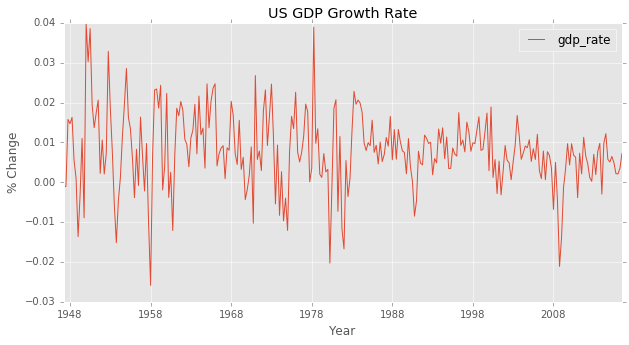

In [20]:
#plot rate of GDP change
plt.figure(figsize=(10,5))
plt.title('US GDP Growth Rate')
plt.plot(gdp_data['end_date'], gdp_data['gdp_rate'])
plt.xlabel('Year')
plt.ylabel('% Change')
plt.legend()
plt.show()

<h1>New Article Data Collection</h1>
The New York Times (NYT) provides an Article Search API to fetch data related to news articles. This API does not return full text of articles, but it will return a number of helpful metadata such as subject terms, abstract, lead paragraph, and date, as well as URLs, which one could conceivably use to scrape the full text of articles. For this project we will be collecting lead paragraph for business articles for specified time period.
In order to request data from NYT an API key must be requested from http://developer.nytimes.com/. The article search API is limited to 1K calls per day, and 5 calls per second. These limits impose challenge for collecting as much data as possible for a day and time period. Based on the limited time for the project, the data collection was limited to two API calls or 20 article per day. This allowed to request 500 days worth of data per day.
A python wrapper was developed around NYT Article Search API to get articles for a given start and end date. The reqested lead paragraph data are then store in a file with file name reflecting the day in the format YYYYMMDD.txt

In [21]:
# Data collection using NYTimes API
class NYTArticlesApi(object):
    def __init__(self, api_key):
        self.api_key = api_key
        self.url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json'

    def request_articles(self, start_date, end_date, page):
        start_date_str = start_date.strftime('%Y%m%d')
        end_date_str = end_date.strftime('%Y%m%d')

        params = {
            'api-key': self.api_key,
            'fq': "section_name:Business",
            'begin_date': start_date_str,
            'end_date': end_date_str,
            'fl': "lead_paragraph",
            'sort': "newest",
            'page': page
        }
        r = requests.get(self.url, params=params)

        if r.status_code == 200:
            response = json.loads(r.text)
            docs = response['response']['docs']
            return [item['lead_paragraph'] for item in docs]

        print "Error: api response: ", r.status_code, "Message :", r.text
        return None

    def fetch_articles(self, start_date, end_date, data_dir):
        cur_date = start_date
        while cur_date >= end_date:
            print 'Processing ', cur_date, '...'
            articles = []
            # get 2 pages for each day, i.e. 20 articles
            for page in range(2):
                articles_page = self.request_articles(cur_date, cur_date, page)
                if articles_page:
                    articles += articles_page
                else:
                    print "No data for page {0}.".format(page)
                    time.sleep(1)
                    break
                time.sleep(1)

            if len(articles) > 0:
                file_name = data_dir + cur_date.strftime('%Y%m%d') + '.txt'
                with open(file_name, 'wb',) as f:
                    for text in articles:
                        if text:
                            f.write(text.encode('utf-8').strip() + '\n')

            else:
                print "Error fetching articles for {0}.".format(cur_date)
                file_name = data_dir + "last_date.txt"
                with open(file_name, 'wb',) as f:
                    f.write(cur_date.strftime('%Y%m%d'))
                return

            cur_date -= timedelta(days=1)

In [23]:
# Class to load data in a SQLite database
class SqliteDB(object):
    def __init__(self, db_file):
        self.db_file = db_file
        self.con = sqlite.connect(db_file)
        self.cur = self.con.cursor()
    
    def close_connection(self):
        self.con.close()
        
    def create_articles_table(self):
        self.cur.execute("CREATE TABLE Articles(Day DATE, ArticleId INT, Article TEXT, UNIQUE(Day, ArticleId) ON CONFLICT REPLACE)")

    def insert_articles(self, file_name, cur_date):
        with open(file_name, 'rb',) as f:
            articles = f.readlines()

        for i, article in enumerate(articles):
            article = article.replace('\'', '')
            self.cur.execute("INSERT INTO Articles VALUES('{0}','{1}','{2}')".format(cur_date, i, article))


    def insert_data(self, data_dir, start_date, end_date):
        print start_date, end_date
        cur_date = start_date
        while cur_date >= end_date:
            cur_date_str = cur_date.strftime('%Y-%m-%d')
            print cur_date_str
            file_name = data_dir + cur_date.strftime('%Y%m%d') + '.txt'
            # print file_name
            if os.path.exists(file_name):
                self.insert_articles(file_name, cur_date_str)

            cur_date -= timedelta(days=1)
        
        self.con.commit()
            
    def query_data(self, query):
        df = pd.read_sql(query, self.con)
        return df;

## Load News Articles collected from NewYork Times

In [24]:
def load_data(data_dir, start_date, end_date):
    data = {}
    cur_date = start_date
    while cur_date >= end_date:
        file_name = data_dir + cur_date.strftime('%Y%m%d') + '.txt'
        if os.path.exists(file_name):
            with open(file_name, 'rb',) as f:
                articles = f.readlines()
            data[cur_date] = " ".join(articles)

        cur_date -= timedelta(days=1)

    return data

In [25]:
db = SqliteDB('../data/articles.sqlite')
query = "SELECT strftime(\"%Y\", Day) as 'year', count(*) as 'count' FROM Articles group by strftime(\"%Y\", Day)"
df = db.query_data(query)

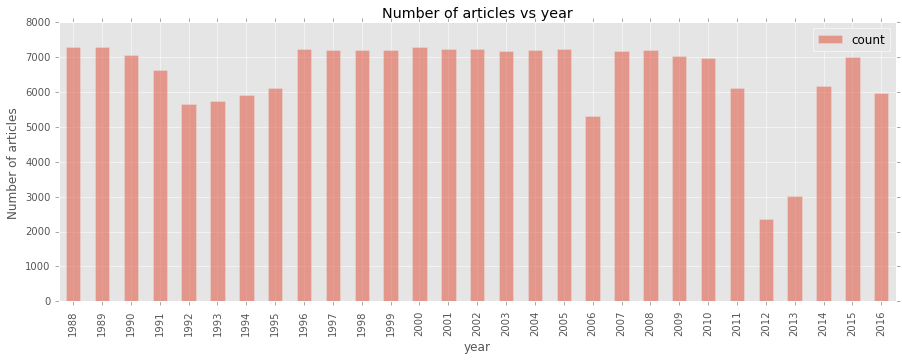

In [26]:
f, axs = plt.subplots(1,1,figsize=(15,5))
plt.title('Number of articles vs year')
plt.ylabel('Number of articles')
df.plot(kind='bar', x='year', y='count', ax=axs, alpha=0.5)
plt.show()

In [27]:
def load_articles(start_date, end_date):
    data = pd.DataFrame()
    cur_date = start_date
    while cur_date <= end_date:
        next_date = cur_date + timedelta(days=30)
        query = "SELECT Day as day, Article as articles FROM Articles where Day >= '{0}' and Day <='{1}'".format(cur_date, next_date)
        df = db.query_data(query)
        df['date'] = pd.to_datetime(df['day'])
        df = df.drop('day', 1)
        df['month'] = df['date'].apply(lambda d: str(d.year) + '-' + str(d.month))
        df['quarter'] = df['date'].apply(lambda d: str(d.year) + 'q' + str((d.month-1)//3+1))
        
        data = data.append(df)

        cur_date = next_date + timedelta(days=1)
        
    return data

In [28]:
start_date = datetime(year=1988, month=1, day=1).date()
end_date = datetime(year=2016, month=10, day=31).date()

all_data = load_articles(start_date, end_date)
all_data.head()

,articles,date,month,quarter
0,"LEAD: The Onset Corporation, an acquisition co...",1988-01-01,1988-1,1988q1
1,LEAD: *3*** COMPANY REPORTS ** *3*INTEGRATED G...,1988-01-01,1988-1,1988q1
2,LEAD: Orders to the nations factories edged up...,1988-01-01,1988-1,1988q1
3,LEAD: Texaco Inc. intends to borrow $3.4 billi...,1988-01-01,1988-1,1988q1
4,LEAD: INTERNATIONAL The dollar ended a bleak y...,1988-01-01,1988-1,1988q1


In [29]:
# join all articles to form single string
articles = all_data.groupby('quarter')['articles'].apply(lambda x: "".join(x))
# remove LEAD: from api text, convert to lower case
articles = articles.apply(lambda x: x.replace("LEAD:", '').lower())
articles = articles.to_frame().reset_index()
articles.head()

,quarter,articles
0,1988q1,"the onset corporation, an acquisition company..."
1,1988q2,*3*** company reports ** *3*quick & reilly gr...
2,1988q3,prime minister margaret thatcher of britain s...
3,1988q4,"delchamps inc., a regional supermarket chain ..."
4,1989q1,magazine redesigns are not aimed only at garn...


In [30]:
# merge gdp rate and articles datasets
dataset = pd.merge(articles, gdp_data, on='quarter')
dataset.head()

,quarter,articles,gdp_current,gdp_chained,start_date,end_date,gdp_rate
0,1988q1,"the onset corporation, an acquisition company...",5090.6,8339.3,1988-01-01,1988-01-01,0.005619
1,1988q2,*3*** company reports ** *3*quick & reilly gr...,5207.7,8449.5,1988-04-01,1988-04-01,0.013215
2,1988q3,prime minister margaret thatcher of britain s...,5299.5,8498.3,1988-07-01,1988-07-01,0.005775
3,1988q4,"delchamps inc., a regional supermarket chain ...",5412.7,8610.9,1988-10-01,1988-10-01,0.013250
4,1989q1,magazine redesigns are not aimed only at garn...,5527.4,8697.7,1989-01-01,1989-01-01,0.010080


In [31]:
# save dataset to csv file
dataset.to_csv('dataset.csv', sep='\t', encoding='utf-8', index=False)

## Calculate Sentiment scores for each quarter

In [32]:
dataset = pd.read_csv('dataset.csv', sep='\t', encoding='utf8')
dataset.head()

,quarter,articles,gdp_current,gdp_chained,start_date,end_date,gdp_rate
0,1988q1,"the onset corporation, an acquisition company...",5090.6,8339.3,1988-01-01,1988-01-01,0.005619
1,1988q2,*3*** company reports ** *3*quick & reilly gr...,5207.7,8449.5,1988-04-01,1988-04-01,0.013215
2,1988q3,prime minister margaret thatcher of britain s...,5299.5,8498.3,1988-07-01,1988-07-01,0.005775
3,1988q4,"delchamps inc., a regional supermarket chain ...",5412.7,8610.9,1988-10-01,1988-10-01,0.013250
4,1989q1,magazine redesigns are not aimed only at garn...,5527.4,8697.7,1989-01-01,1989-01-01,0.010080


In [33]:
# Calculate the sentiments score for the words. 
def get_sentiment_score(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    sentences = nltk.sent_tokenize(text)
    pos_score = 0
    neg_score = 0
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        pos_words = nltk.pos_tag(words)
        for (word, pos) in pos_words:
            curr_pos_score = 0
            curr_neg_score = 0
#             if pos.startswith('NN'): 
#                 words_to_keep.append(wordnet_lemmatizer.lemmatize(word,wn.NOUN))
# #                 synset = lesk(sentence, word, wn.NOUN)
#                 if(synset):
#                     senti = swn.senti_synset(synset.name())
            if pos.startswith('JJ'):
                words_to_keep.append(wordnet_lemmatizer.lemmatize(word,wn.ADJ))
                synset = lesk(sentence, word, wn.ADJ)
                if(synset):
                    senti = swn.senti_synset(synset.name())
                    curr_pos_score = senti.pos_score()
                    curr_neg_score = senti.neg_score()
            elif pos.startswith('VB'):
                synset = lesk(sentence, word, wn.VERB)
                if(synset):
                    senti = swn.senti_synset(synset.name())
                    curr_pos_score = senti.pos_score()
                    curr_neg_score = senti.neg_score()
            elif pos.startswith('RB'):
                synset = lesk(sentence, word, wn.ADV)
                if(synset):
                    senti = swn.senti_synset(synset.name())
                    curr_pos_score = senti.pos_score()
                    curr_neg_score = senti.neg_score()
        
            pos_score = pos_score + curr_pos_score
            neg_score = neg_score + curr_neg_score
    
    return (pos_score, neg_score)

**Note**: The below process takes upto 40 minutes to compute the sentiment score.

In [ ]:
dataset['sentiment_scores'] = dataset['articles'].apply(lambda x: get_sentiment_score(x))

In [36]:
dataset[['pos_sentiment_score', 'neg_sentiment_score']] = dataset['sentiment_scores'].apply(pd.Series)
dataset.drop('sentiment_scores', inplace=True, axis=1)
dataset.to_csv("quarter_sentiment_scores.csv", index=False, encoding='utf-8')
dataset.head()

,quarter,articles,gdp_current,gdp_chained,start_date,end_date,rate,gdp_rate,pos_sentiment_score,neg_sentiment_score
0,1988q1,"the onset corporation, an acquisition company...",5090.6,8339.3,1988-01-01,1988-01-01,0.005619,0.005619,479.750,422.500
1,1988q2,*3*** company reports ** *3*quick & reilly gr...,5207.7,8449.5,1988-04-01,1988-04-01,0.013215,0.013215,550.306,486.569
2,1988q3,prime minister margaret thatcher of britain s...,5299.5,8498.3,1988-07-01,1988-07-01,0.005775,0.005775,530.222,477.653
3,1988q4,"delchamps inc., a regional supermarket chain ...",5412.7,8610.9,1988-10-01,1988-10-01,0.013250,0.013250,540.739,464.011
4,1989q1,magazine redesigns are not aimed only at garn...,5527.4,8697.7,1989-01-01,1989-01-01,0.010080,0.010080,513.239,460.261


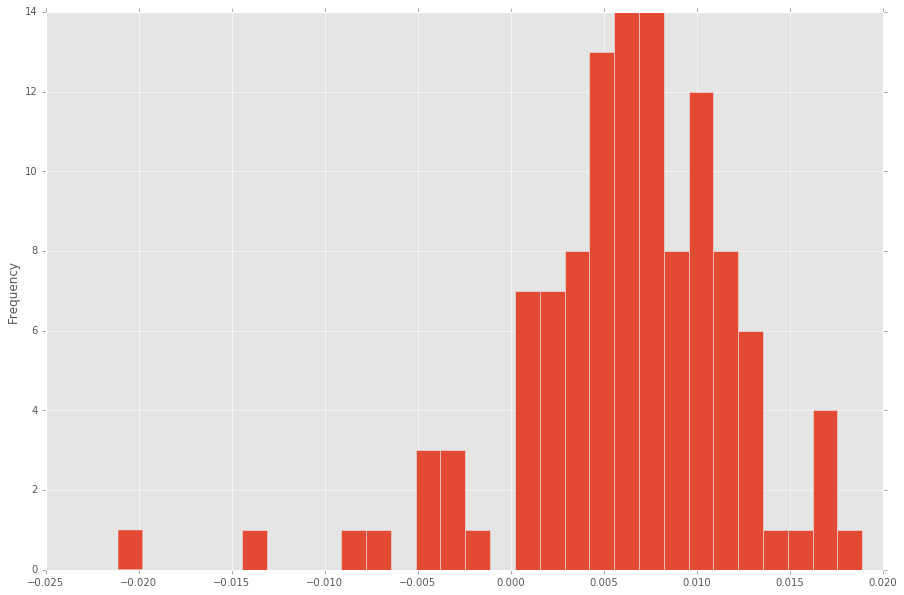

In [45]:
#Plot the GDP Rate change
dataset.rate.plot(kind = "hist", bins = 30)

## Basic Time Series Model



We will build a time-series forecasting model to get a forecast for U.S. GDP. Let us start with the three most basic models

-- Mean Constant Model

-- Linear Trend Model

-- Random Walk Model

## Mean Model



This very simple forecasting model will be called the "mean model"

In [46]:
df = pd.read_csv("quarter_sentiment_scores.csv", encoding='utf-8')
# df.index = pd.Index(sm.tsa.datetools.dates_from_range('1988Q1', '2016Q3'))
df['date'] = pd.to_datetime(df['start_date'])
# Let us store this as our Mean Predication Value
df["rateMean"] = df.rate.mean()
df.head()

,quarter,articles,gdp_current,gdp_chained,start_date,end_date,rate,gdp_rate,pos_sentiment_score,neg_sentiment_score,date,rateMean
0,1988q1,"the onset corporation, an acquisition company...",5090.6,8339.3,1988-01-01,1988-01-01,0.005619,0.005619,479.750,422.500,1988-01-01,0.006125
1,1988q2,*3*** company reports ** *3*quick & reilly gr...,5207.7,8449.5,1988-04-01,1988-04-01,0.013215,0.013215,550.306,486.569,1988-04-01,0.006125
2,1988q3,prime minister margaret thatcher of britain s...,5299.5,8498.3,1988-07-01,1988-07-01,0.005775,0.005775,530.222,477.653,1988-07-01,0.006125
3,1988q4,"delchamps inc., a regional supermarket chain ...",5412.7,8610.9,1988-10-01,1988-10-01,0.013250,0.013250,540.739,464.011,1988-10-01,0.006125
4,1989q1,magazine redesigns are not aimed only at garn...,5527.4,8697.7,1989-01-01,1989-01-01,0.010080,0.010080,513.239,460.261,1989-01-01,0.006125


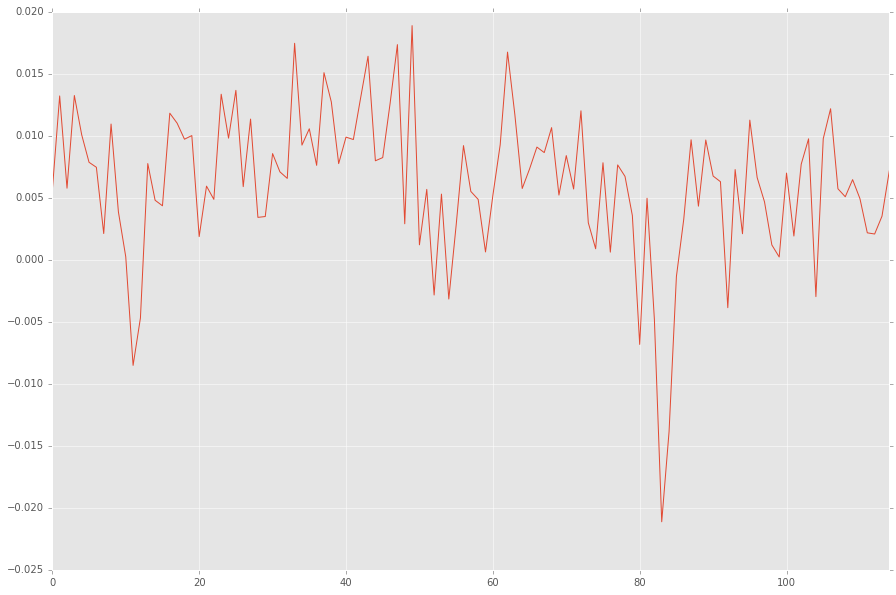

In [47]:
#Plot a line graph for rate and rateMean
df.rate.plot(kind="line", x="date", y = ["rate", "rateMean"])

In [48]:
# Use the root mean square error to calculate error values
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [49]:
model_mean_RMSE = RMSE(df.rateMean, df.rate)
model_mean_RMSE

0.0059907338822815003

In [50]:
# Save this in a dataframe
dfResults = pd.DataFrame(columns = ["Model", "Forecast", "RMSE", "AIC", "BIC","ADF","Durbin"])

dfResults.loc[0,"Model"] = "Mean"
dfResults.loc[0,"Forecast"] = df.rate.mean()
dfResults.loc[0,"RMSE"] = model_mean_RMSE
dfResults.loc[0,"AIC"] = "NA"
dfResults.loc[0,"BIC"] = "NA"
dfResults.loc[0,"ADF"] = "NA"
dfResults.loc[0,"Durbin"] = "NA"
dfResults.head()


,Model,Forecast,RMSE,AIC,BIC,ADF,Durbin
0,Mean,0.00612483,0.00599073,NA,NA,NA,NA


## Linear Trend Model



Plotting a linear trend model between rate and time where we create a numeric indicator for time period.

In [54]:
# Convert date in datetimedelta figure starting from zero
df["timeIndex"] = df.date - df.date.min()
# Convert to months using the timedelta function
df["timeIndex"] = df["timeIndex"]/np.timedelta64(1, 'M')
df["timeIndex"] = df["timeIndex"].round(0).astype(int)
df.timeIndex.head()

0     0
1     3
2     6
3     9
4    12
Name: timeIndex, dtype: int64

In [56]:
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller


## Now plot linear regression between priceMod and timeIndex
model_linear = smf.ols('rate ~ timeIndex', data = df).fit()

model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     6.296
Date:                Wed, 14 Dec 2016   Prob (F-statistic):             0.0135
Time:                        22:24:41   Log-Likelihood:                 428.46
No. Observations:                 115   AIC:                            -852.9
Df Residuals:                     113   BIC:                            -847.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.0085      0.001      7.788      0.000         0.006     0.011
timeIndex  -1.382e-05   5.51e-06     -2.509      0.014     -2.47e-05 -2.91e-06
==============================================================================
Omnibus:                       36.358   Durbin-Watson:                   1.253
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.303
Skew:                          -1.215   Prob(JB):                     1.82e-19
Kurtosis:                       6.479   Cond. No.                         393.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

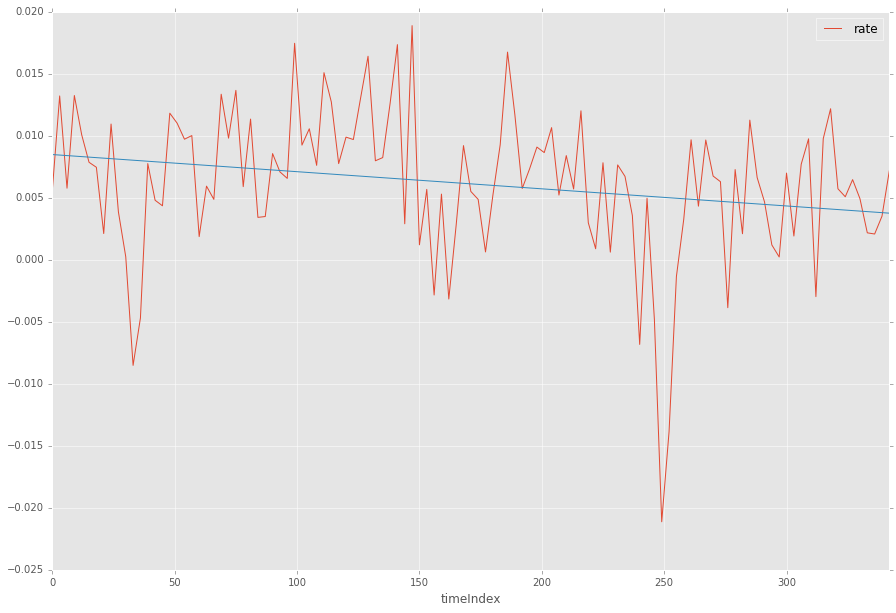

In [58]:
model_linear_pred = model_linear.predict()

# Plot the prediction line
df.plot(kind="line", x="timeIndex", y = "rate")
plt.plot(df.timeIndex,model_linear_pred, '-')

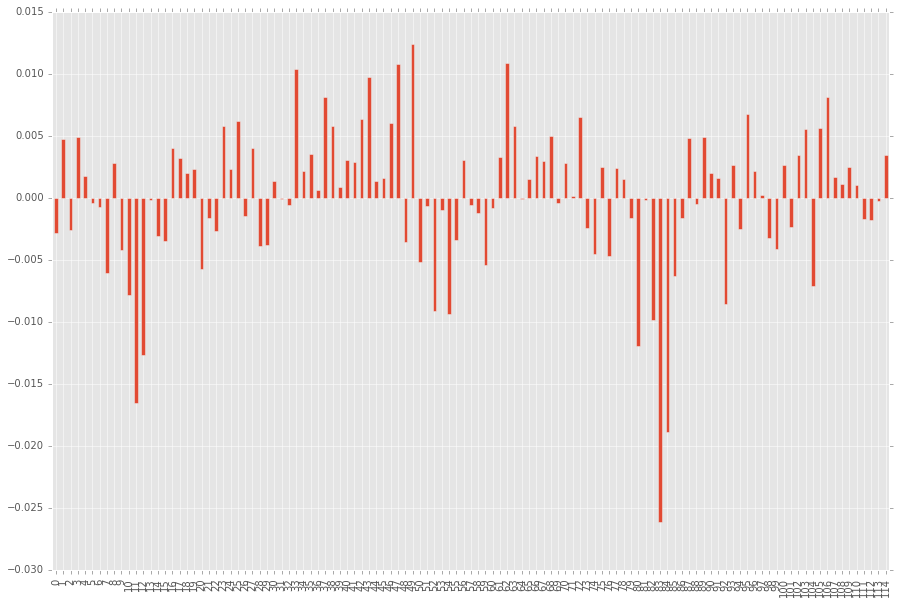

In [59]:
#Plot the model residual

model_linear.resid.plot(kind = "bar")

It is seen in the two plots above that the linear trend model has a tendency to make an error of the same sign for many periods in a row (experiencing autocorrelation). We can measure this tendency by the  Durbin-Watson statistic. If there is no time pattern, the Durbin-Watson statistic ought to be very close to 2, which is not the case here. 

If the model has succeeded in extracting all the "signal" from the data, there should be no pattern at all in the errors: the error in the next period should not be correlated with any previous errors. The linear trend model obviously fails the autocorrelation test in this case.

In [60]:
# Using Predict Function
model_linear_forecast_auto = model_linear.predict(exog = dict(timeIndex=113))
model_linear_forecast_auto

array([ 0.00692634])

In [61]:
df["rateLinear"] = model_linear_pred
df.head()

,quarter,articles,gdp_current,gdp_chained,start_date,end_date,rate,gdp_rate,pos_sentiment_score,neg_sentiment_score,date,rateMean,timeIndex,rateLinear
0,1988q1,"the onset corporation, an acquisition company...",5090.6,8339.3,1988-01-01,1988-01-01,0.005619,0.005619,479.750,422.500,1988-01-01,0.006125,0,0.008488
1,1988q2,*3*** company reports ** *3*quick & reilly gr...,5207.7,8449.5,1988-04-01,1988-04-01,0.013215,0.013215,550.306,486.569,1988-04-01,0.006125,3,0.008446
2,1988q3,prime minister margaret thatcher of britain s...,5299.5,8498.3,1988-07-01,1988-07-01,0.005775,0.005775,530.222,477.653,1988-07-01,0.006125,6,0.008405
3,1988q4,"delchamps inc., a regional supermarket chain ...",5412.7,8610.9,1988-10-01,1988-10-01,0.013250,0.013250,540.739,464.011,1988-10-01,0.006125,9,0.008364
4,1989q1,magazine redesigns are not aimed only at garn...,5527.4,8697.7,1989-01-01,1989-01-01,0.010080,0.010080,513.239,460.261,1989-01-01,0.006125,12,0.008322


In [62]:
# Root Mean Squared Error (RMSE)
model_linear_RMSE = RMSE(df.rateLinear, df.rate)
model_linear_RMSE


0.0058305101222343291

In [65]:
dfResults.loc[1,"Model"] = "Linear"
dfResults.loc[1,"Forecast"] = model_linear_forecast_auto
dfResults.loc[1,"RMSE"] = model_linear_RMSE
dfResults.loc[1,"AIC"] = model_linear.aic
dfResults.loc[1,"BIC"] = model_linear.bic
dfResults.loc[1,"ADF"] = "NA"
dfResults.loc[1,"Durbin"] = sm.stats.durbin_watson(model_linear.resid)
dfResults.head()

,Model,Forecast,RMSE,AIC,BIC,ADF,Durbin
0,Mean,0.00612483,0.00599073,NA,NA,NA,NA
1,Linear,[0.00692634334447],0.00583051,-852.914,-847.424,NA,1.25307


## Linear Model with Regressor

In [67]:
## Now plot linear regression between rate and pos score, neg score and timeIndex
model_linear_scores = smf.ols('rate ~ timeIndex + pos_sentiment_score + neg_sentiment_score', data = df).fit()

model_linear_scores.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rate   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     5.833
Date:                Wed, 14 Dec 2016   Prob (F-statistic):           0.000974
Time:                        22:27:20   Log-Likelihood:                 433.76
No. Observations:                 115   AIC:                            -859.5
Df Residuals:                     111   BIC:                            -848.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept               0.0041      0.002      2.041      0.044         0.000     0.008
timeIndex           -5.685e-06   6.09e-06     -0.933      0.353     -1.78e-05  6.39e-06
pos_sentiment_score  3.144e-05   1.06e-05      2.974      0.004      1.05e-05  5.24e-05
neg_sentiment_score -3.057e-05   1.09e-05     -2.815      0.006     -5.21e-05 -9.05e-06
==============================================================================
Omnibus:                       30.143   Durbin-Watson:                   1.458
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.450
Skew:                          -1.073   Prob(JB):                     7.47e-14
Kurtosis:                       5.831   Cond. No.                     6.35e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As we can see from the summary, the model performs better when using the sentiment scores as predictors, however, most of the summary statistics show the same problems we identified in the linear trend model above.

## Baseline Model: Random Walk

# Baseline Model: Random Walk, AR(1)

Instead of predicting the quantity of Yt, it may be better to try to predict the change that occurs from one period to the next (i.e., the quantity Yt - Yt-1). The simplest case of such a model is one that always predicts that the next change will be zero, as if the series is equally likely to go up or down in the next period regardless of what it has done in the past.

Random Walk Model $$ \hat{Y_t} = Y_{t-1} + \epsilon \\$$


In [70]:
df.set_index(['date'], inplace=True, drop=True)
arma_mod10 = sm.tsa.ARMA(df.gdp_rate, (1,0)).fit()

In [72]:
df["rateShift1"] = df.rate.shift()
df["posShift1"] = df.pos_sentiment_score.shift()
df["negShift1"] = df.neg_sentiment_score.shift()

df.head()

,quarter,articles,gdp_current,gdp_chained,start_date,end_date,rate,gdp_rate,pos_sentiment_score,neg_sentiment_score,rateMean,timeIndex,rateLinear,rateShift1,posShift1,negShift1
date,,,,,,,,,,,,,,,,
1988-01-01,1988q1,"the onset corporation, an acquisition company...",5090.6,8339.3,1988-01-01,1988-01-01,0.005619,0.005619,479.750,422.500,0.006125,0,0.008488,NaN,NaN,NaN
1988-04-01,1988q2,*3*** company reports ** *3*quick & reilly gr...,5207.7,8449.5,1988-04-01,1988-04-01,0.013215,0.013215,550.306,486.569,0.006125,3,0.008446,0.005619,479.750,422.500
1988-07-01,1988q3,prime minister margaret thatcher of britain s...,5299.5,8498.3,1988-07-01,1988-07-01,0.005775,0.005775,530.222,477.653,0.006125,6,0.008405,0.013215,550.306,486.569
1988-10-01,1988q4,"delchamps inc., a regional supermarket chain ...",5412.7,8610.9,1988-10-01,1988-10-01,0.013250,0.013250,540.739,464.011,0.006125,9,0.008364,0.005775,530.222,477.653
1989-01-01,1989q1,magazine redesigns are not aimed only at garn...,5527.4,8697.7,1989-01-01,1989-01-01,0.010080,0.010080,513.239,460.261,0.006125,12,0.008322,0.013250,540.739,464.011


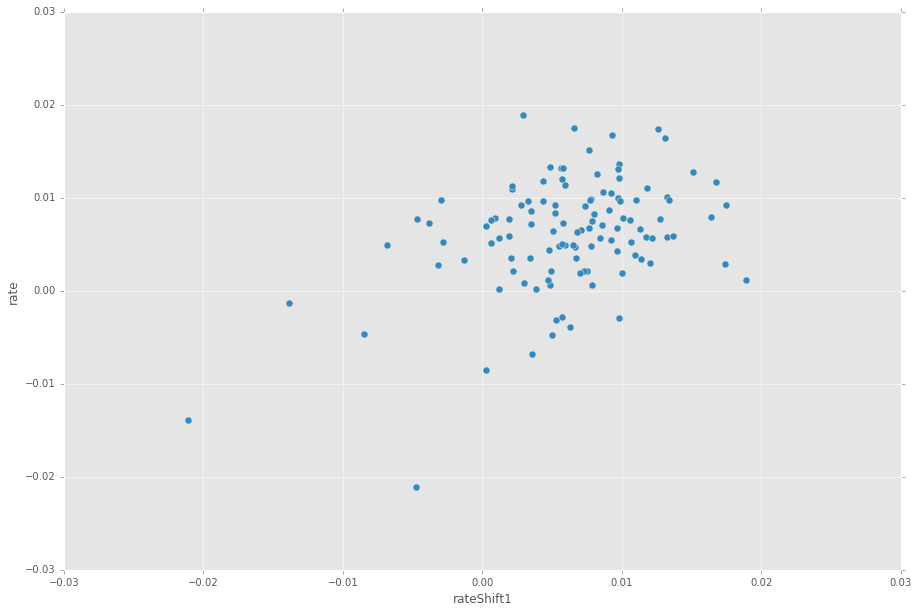

In [74]:
#Plot rate Vs rateShift calculated above
df.plot(kind= "scatter", y = "rate", x = "rateShift1", s = 50)

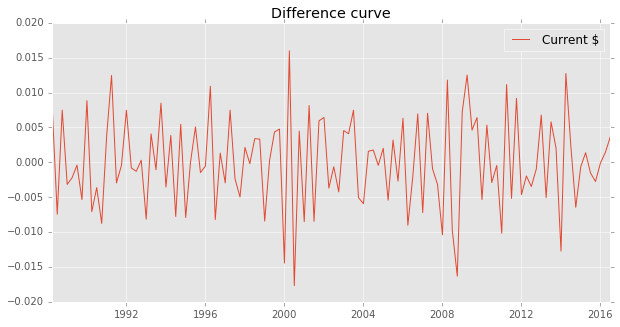

In [77]:
# Lets plot the one-month difference curve
df["rateDiff"] = df.rate - df.rateShift1
df["posDiff"] = df.pos_sentiment_score - df.posShift1
df["negDiff"] = df.neg_sentiment_score - df.negShift1

# df.rateDiff.plot()


#plot GDP trend
plt.figure(figsize=(10,5))
plt.title('Difference curve')
plt.plot(df.index, df["rateDiff"], label='Current $')
plt.legend()
plt.show()

In [78]:
df["rateRandom"] = df.rateShift1

In [79]:
# Root Mean Squared Error (RMSE)
model_random_RMSE = RMSE(df.rateRandom, df.rate)
model_random_RMSE

dfResults.loc[2,"Model"] = "Baseline AR(1)"
dfResults.loc[2,"Forecast"] = df.rateShift1[-1]
dfResults.loc[2,"RMSE"] = model_random_RMSE
dfResults.loc[2,"AIC"] = arma_mod10.aic
dfResults.loc[2,"BIC"] = arma_mod10.bic
dfResults.loc[2,"ADF"] = "NA"
dfResults.loc[2,"Durbin"] = sm.stats.durbin_watson(arma_mod10.resid)

dfResults.head()

,Model,Forecast,RMSE,AIC,BIC,ADF,Durbin
0,Mean,0.00612483,0.00599073,NA,NA,NA,NA
1,Linear,[0.00692634334447],0.00583051,-852.914,-847.424,NA,1.25307
2,Baseline AR(1),0.00351589,0.00655506,-865.267,-857.032,NA,2.15719


## Advanced Model

Most of the time series models work on the assumption that the time series is stationary. Intuitively, we can see that if a time series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 

There are three basic criterion for a series to be classified as stationary series : constant mean, variance is not a a function of time. and covariance is not a function of time.

### How do we check for Stationarity in a series?

Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time.

Dickey-Fuller Test: Checking stationarity the null hypothesis is that the time series is non-stationary. If our conclusion is to reject the null hypothesis then we say that the series is stationary.


### Augmented Dickey Fuller Test of Stationarity

The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.
$$ Y_t = \rho * Y_{t-1} + \epsilon_t \\$$$$ Y_t - Y_{t-1} = (\rho - 1) Y_{t - 1} + \epsilon_t \\$$

We have to test if p – 1 is significantly different than zero or not. If the null hypothesis gets rejected, we’ll get a stationary time series.

In [80]:
# Custom function to calcualte Augumented Dickey Fuller score

def adf(ts):
    
    # Determing rolling statistics
    rolmean = pd.rolling_mean(ts, window=12)
    rolstd = pd.rolling_std(ts, window=12)

    #Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Calculate ADF factors
    adftest = adfuller(ts, autolag='AIC')
    adfoutput = pd.Series(adftest[0:4], index=['Test Statistic','p-value','# of Lags Used',
                                              'Number of Observations Used'])
    for key,value in adftest[4].items():
        adfoutput['Critical Value (%s)'%key] = value
    return adfoutput


### How to make a Time Series Stationary?

There are 3 major reasons behind non-stationarity:

**Trend:** A trend exists when there is a long-term increase or decrease in the data.
**Seasonal:** A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
**Cyclic:** A cyclic pattern exists when data exhibit rises and falls that are not of fixed period.

## Forecasting Steps

The underlying principle is to model or estimate the trend and seasonality in the series and remove those from the series to get a stationary series. Then statistical forecasting techniques can be implemented on this series. The final step would be to convert the forecasted values into the original scale by applying trend and seasonality constraints back.


## Estimating and Eliminating Trend

1. Transformation - Take a log, sqrt, cuberoot etc. transformation
2. Aggregation – taking average for a time period like monthly/weekly averages
3. Smoothing – taking rolling averages, exponential smoothing
4. Polynomial Fitting – fit a regression model

## Simple Moving Average

A moving average is often called a "smoothed" version of the original series because short-term averaging has the effect of smoothing out the bumps in the original series.

Simple Moving Average (SMA)
$$ \hat{y_t} = \frac{y_{t-1} + y_{t-2} + y_{t-3} + ... + y_{t-m}}{m} \\$$ 

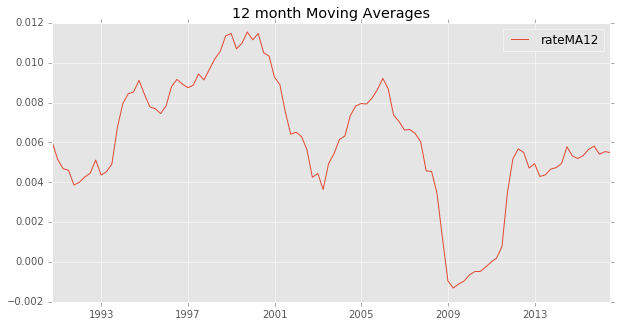

In [83]:
# For smoothing the values we can use 12 month Moving Averages 
df['rateMA12'] = pd.rolling_mean(df.rate, window = 12)

# df.plot(kind ="line", y=["rateMA12", "rate"])

plt.figure(figsize=(10,5))
plt.title('12 month Moving Averages')
plt.plot(df.index, df["rateMA12"])
plt.legend()
plt.show()

In [84]:
df["rateMA12"] = df.rateMA12


model_MA12_forecast = df.rate.tail(12).mean()

# Root Mean Squared Error (RMSE)
model_MA12_RMSE = RMSE(df.rateMA12, df.rate)

dfResults.loc[3,"Model"] = "Moving Average 12"
dfResults.loc[3,"Forecast"] = model_MA12_forecast
dfResults.loc[3,"RMSE"] = model_MA12_RMSE
dfResults.loc[3,"AIC"] = "NA"
dfResults.loc[3,"BIC"] = "NA"
dfResults.loc[3,"ADF"] = -4.68909
dfResults.loc[3,"Durbin"] = "NA"
dfResults.head()

,Model,Forecast,RMSE,AIC,BIC,ADF,Durbin
0,Mean,0.00612483,0.00599073,NA,NA,NA,NA
1,Linear,[0.00692634334447],0.00583051,-852.914,-847.424,NA,1.25307
2,Baseline AR(1),0.00351589,0.00655506,-865.267,-857.032,NA,2.15719
3,Moving Average 12,0.0054909,0.00565895,NA,NA,-4.68909,NA


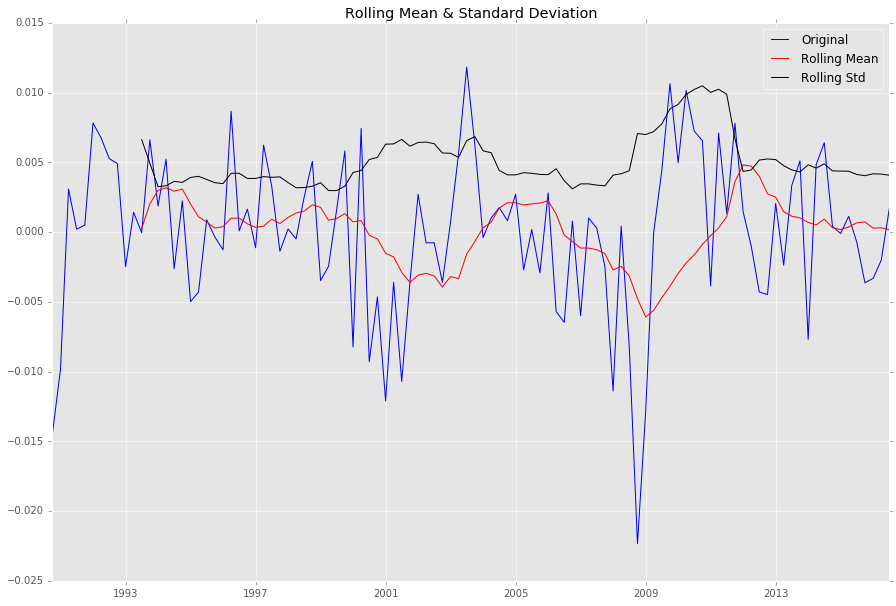

Test Statistic                  -5.295444
p-value                          0.000006
# of Lags Used                   1.000000
Number of Observations Used    102.000000
Critical Value (5%)             -2.890321
Critical Value (1%)             -3.496149
Critical Value (10%)            -2.582122
dtype: float64

In [85]:
# Test remaining part for Stationary
ts = df.rate - df.rateMA12
ts.dropna(inplace = True)
adf(ts)

## Simple Exponential Smoothing Model

Instead of equally weighting each of the observation, in the SES model we give more weightage to the recent observations and less to the older ones. This is done by the using a smoothing variable like alpha

$$ \hat{y_t} = \alpha y_{t-1} + (1-\alpha)\hat{y_{t-1}} \\$$ 

In [86]:
df['rateExp12'] = pd.ewma(df.rate, halflife=12)

halflife = 12
alpha = 1 - np.exp(np.log(0.5)/halflife)
alpha

0.056125687318306472

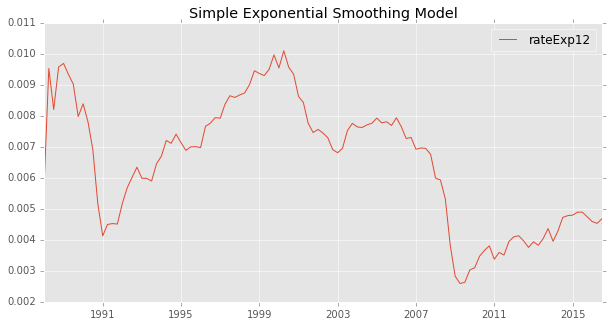

In [89]:
# df.plot(kind ="line", y=["rateExp12", "rate"])
plt.figure(figsize=(10,5))
plt.title('Simple Exponential Smoothing Model')
plt.plot(df.index, df["rateExp12"])
plt.legend()
plt.show()

In [90]:
df["rateExp12"] = df.rateExp12

# Root Mean Squared Error (RMSE)
model_Exp12_RMSE = RMSE(df.rateExp12, df.rate)

y_exp = df.rate[-1]


y_for = df.rateExp12[-1]

model_Exp12_forecast = alpha * y_exp + (1 - alpha) * y_for

dfResults.loc[4,"Model"] = "Exp Smoothing 12"
dfResults.loc[4,"Forecast"] = model_Exp12_forecast
dfResults.loc[4,"RMSE"] = model_Exp12_RMSE
dfResults.loc[4,"AIC"] = "NA"
dfResults.loc[4,"BIC"] = "NA"
dfResults.loc[4,"ADF"] = -5.064625
dfResults.loc[4,"Durbin"] = "NA"

dfResults.head()

,Model,Forecast,RMSE,AIC,BIC,ADF,Durbin
0,Mean,0.00612483,0.00599073,NA,NA,NA,NA
1,Linear,[0.00692634334447],0.00583051,-852.914,-847.424,NA,1.25307
2,Baseline AR(1),0.00351589,0.00655506,-865.267,-857.032,NA,2.15719
3,Moving Average 12,0.0054909,0.00565895,NA,NA,-4.68909,NA
4,Exp Smoothing 12,0.00481839,0.0054583,NA,NA,-5.06463,NA


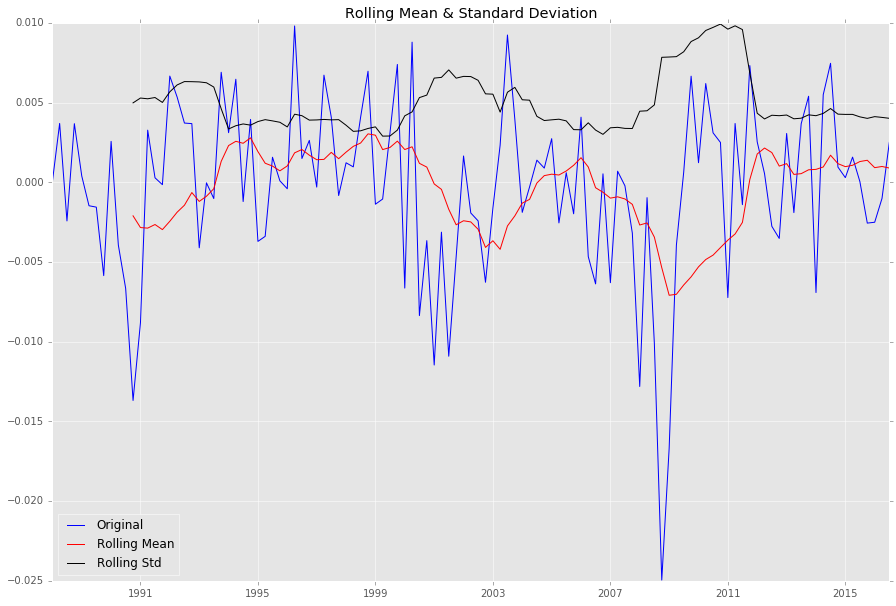

Test Statistic                  -5.097684
p-value                          0.000014
# of Lags Used                   1.000000
Number of Observations Used    113.000000
Critical Value (5%)             -2.887477
Critical Value (1%)             -3.489590
Critical Value (10%)            -2.580604
dtype: float64

In [91]:
# Test remaining part for Stationary
ts = df.rate - df.rateExp12
ts.dropna(inplace = True)
adf(ts)

# Eliminating Trend and Seasonality

Differencing – taking the differece with a particular time lag. One of the most common methods of dealing with both trend and seasonality. This mostly works well in improving stationarity. We have already done first order difference earlier


Decomposition – modeling both trend and seasonality and removing them from the model.


## Time Series Differencing



One of the most common methods of dealing with both trend and seasonality is differencing. In this technique, we take the difference of the observation at a particular instant with that at the previous instant. This mostly works well in improving stationarity. We have already done first order difference earlier


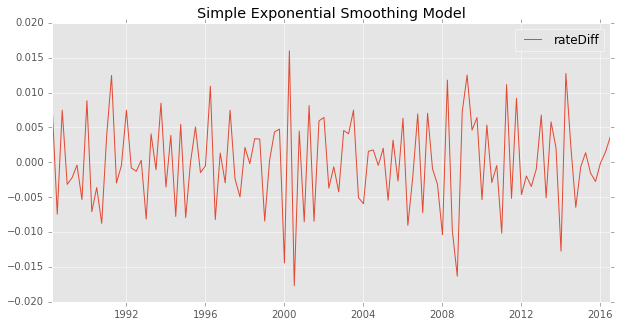

In [92]:
#Plot the rateDiff
plt.figure(figsize=(10,5))
plt.title('Simple Exponential Smoothing Model')
plt.plot(df.index, df["rateDiff"])
plt.legend()
plt.show()

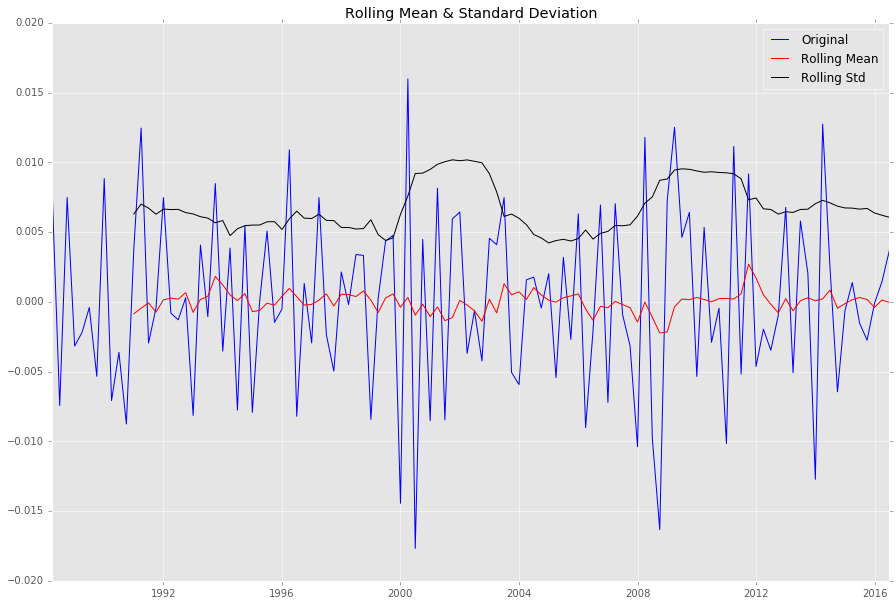

Test Statistic                -5.997242e+00
p-value                        1.690141e-07
# of Lags Used                 7.000000e+00
Number of Observations Used    1.060000e+02
Critical Value (5%)           -2.889217e+00
Critical Value (1%)           -3.493602e+00
Critical Value (10%)          -2.581533e+00
dtype: float64

In [93]:
# Test remaining part for Stationary
ts = df.rateDiff
ts.dropna(inplace = True)
adf(ts)

## Time Series Decomposition



We can also decompose the time series into trend and seasonality

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose

df.index = df.index.to_datetime()

In [108]:
decomposition = seasonal_decompose(df.rate, model = "additive")
# decomposition.plot()

SyntaxError: 'return' outside function (<ipython-input-110-43673bee0824>, line 16)

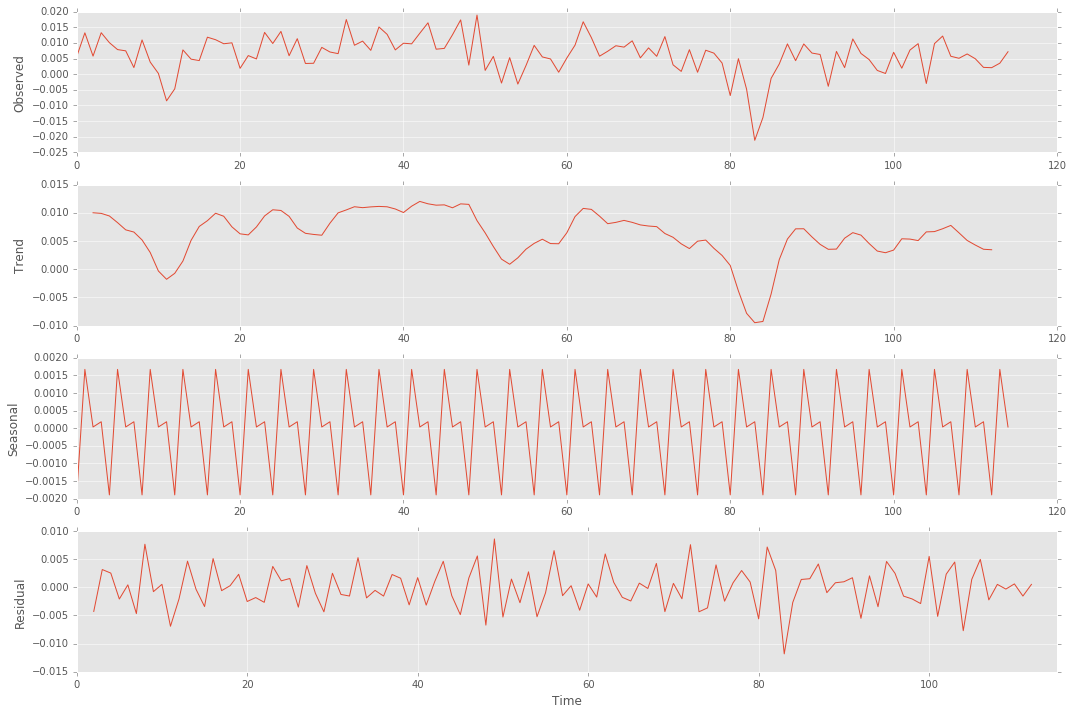

In [110]:
# decomposition.observed.values
fig, axes = plt.subplots(4, 1)

axes[0].plot(decomposition.observed.values)
axes[0].set_ylabel('Observed')
axes[1].plot(decomposition.trend.values)
axes[1].set_ylabel('Trend')
axes[2].plot(decomposition.seasonal.values)
axes[2].set_ylabel('Seasonal')
axes[3].plot(decomposition.resid.values)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Time')
axes[3].set_xlim(0, decomposition.nobs)

fig.tight_layout()
return fig

In [111]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

df["rateDecomp"] = trend + seasonal

# Root Mean Squared Error (RMSE)
model_Decomp_RMSE = RMSE(df.rateDecomp, df.rate)
model_Decomp_RMSE

0.0036400590806209394

In [112]:
dfResults.loc[5,"Model"] = "Decomposition"
dfResults.loc[5,"Forecast"] = df.rate.sub(df.rateDecomp).mean()
dfResults.loc[5,"RMSE"] = model_Decomp_RMSE
dfResults.loc[5,"AIC"] = "NA"
dfResults.loc[5,"BIC"] = "NA"
dfResults.loc[5,"ADF"] = -7.715443e+00
dfResults.loc[5,"Durbin"] = sm.stats.durbin_watson(residual)

dfResults

,Model,Forecast,RMSE,AIC,BIC,ADF,Durbin
0,Mean,0.00612483,0.00599073,NA,NA,NA,NA
1,Linear,[0.00692634334447],0.00583051,-852.914,-847.424,NA,1.25307
2,Baseline AR(1),0.00351589,0.00655506,-865.267,-857.032,NA,2.15719
3,Moving Average 12,0.0054909,0.00565895,NA,NA,-4.68909,NA
4,Exp Smoothing 12,0.00481839,0.0054583,NA,NA,-5.06463,NA
5,Decomposition,-1.19582e-05,0.00364006,NA,NA,-7.71544,NaN


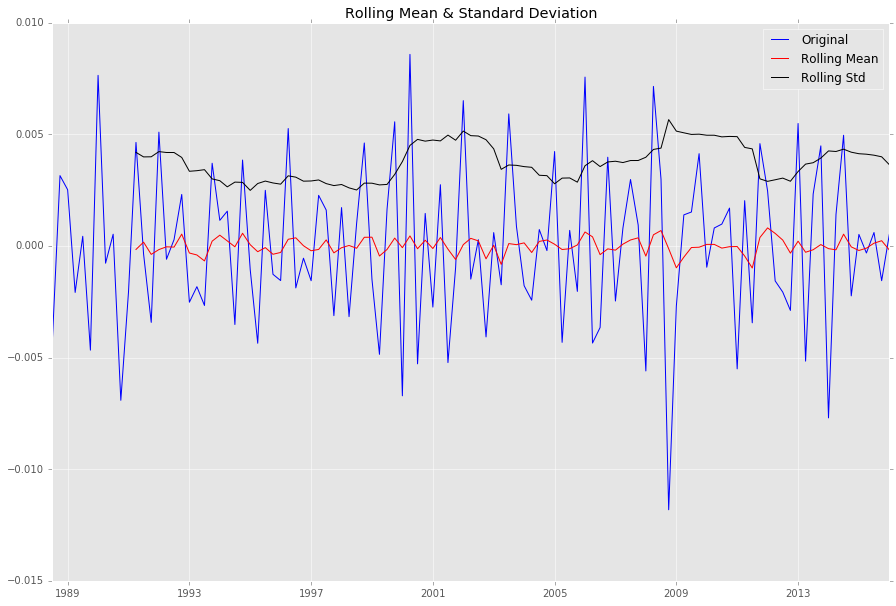

Test Statistic                -7.909309e+00
p-value                        3.987502e-12
# of Lags Used                 8.000000e+00
Number of Observations Used    1.020000e+02
Critical Value (5%)           -2.890321e+00
Critical Value (1%)           -3.496149e+00
Critical Value (10%)          -2.582122e+00
dtype: float64

In [113]:
# Test remaining part for Stationary
ts = decomposition.resid
ts.dropna(inplace = True)
adf(ts)

## Auto Regressive Models

#Auto Regressive Models - AR(p)

In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable.

Thus an autoregressive model of order (p) can be written as
$$ y_t = c + m_1y_{t-1} + m_2y_{t-2} + m_3y_{t-3} + .. \\$$

Random walk model is an AR(1) model with $$m_1=1, c = 0\\$$ 


In [114]:
ts = df.rate
ts_diff = df.rateDiff
ts_diff.dropna(inplace = True)
ex1=df.posDiff
ex2=df.negDiff
ex=np.column_stack((ex1,ex2))

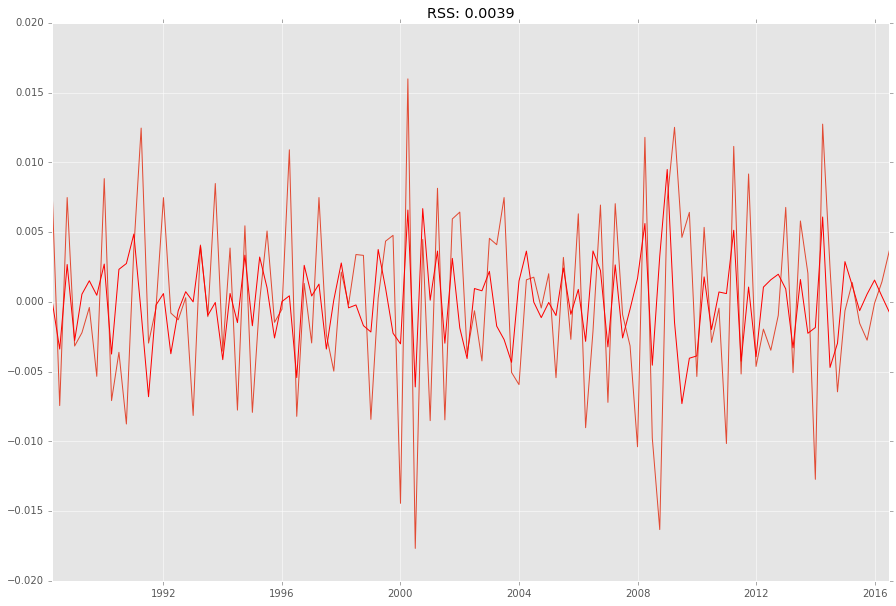

In [115]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_diff, order=(2, 0, 0))  
results_AR = model.fit(exog=ex, disp=-1)  
plt.plot(ts_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_diff)**2))

In [116]:
# call predict
df["rateAR"] = results_AR.predict()

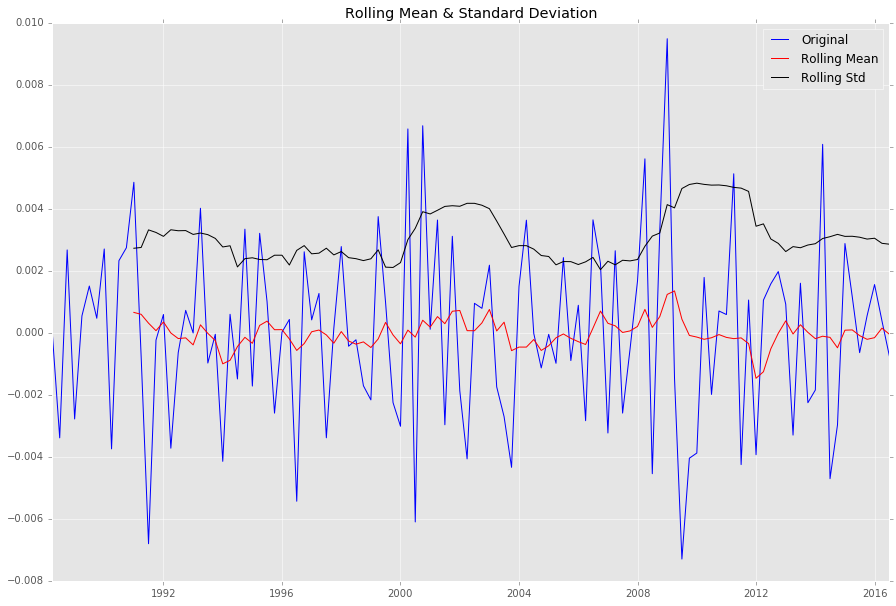

Test Statistic                -6.585419e+00
p-value                        7.335567e-09
# of Lags Used                 4.000000e+00
Number of Observations Used    1.090000e+02
Critical Value (5%)           -2.888444e+00
Critical Value (1%)           -3.491818e+00
Critical Value (10%)          -2.581120e+00
dtype: float64

In [117]:
#Drop NA values from the data
df.rateAR.dropna(inplace=True)
adf(df.rateAR)

In [118]:
# Root Mean Squared Error (RMSE)
model_AR_RMSE = RMSE(df.rateAR, df.rate)
model_AR_RMSE

0.009336475831296721

In [119]:
#Populate the values in the dataframe
dfResults.loc[6,"Model"] = "AR(2) with sentiments"
dfResults.loc[6,"Forecast"] = df.rate.sub(df.rateAR).mean()
dfResults.loc[6,"RMSE"] = model_AR_RMSE
dfResults.loc[6,"AIC"] = results_AR.aic
dfResults.loc[6,"BIC"] = results_AR.bic
dfResults.loc[6,"ADF"] = -6.539006e+00
dfResults.loc[6,"Durbin"] = sm.stats.durbin_watson(results_AR.resid)

dfResults

,Model,Forecast,RMSE,AIC,BIC,ADF,Durbin
0,Mean,0.00612483,0.00599073,NA,NA,NA,NA
1,Linear,[0.00692634334447],0.00583051,-852.914,-847.424,NA,1.25307
2,Baseline AR(1),0.00351589,0.00655506,-865.267,-857.032,NA,2.15719
3,Moving Average 12,0.0054909,0.00565895,NA,NA,-4.68909,NA
4,Exp Smoothing 12,0.00481839,0.0054583,NA,NA,-5.06463,NA
5,Decomposition,-1.19582e-05,0.00364006,NA,NA,-7.71544,NaN
6,AR(2) with sentiments,0.00614539,0.00933648,-841.569,-830.625,-6.53901,2.03833


## Moving Average Models

#Moving Average Model - MA(q)

Rather than use past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model.
$$ y_t=c+e_t+l_1 e_{t−1}+l_2 e_{t−2} + ... + l_q e_{t-q} \\$$

where e is white noise. We refer to this as an MA(q) model.

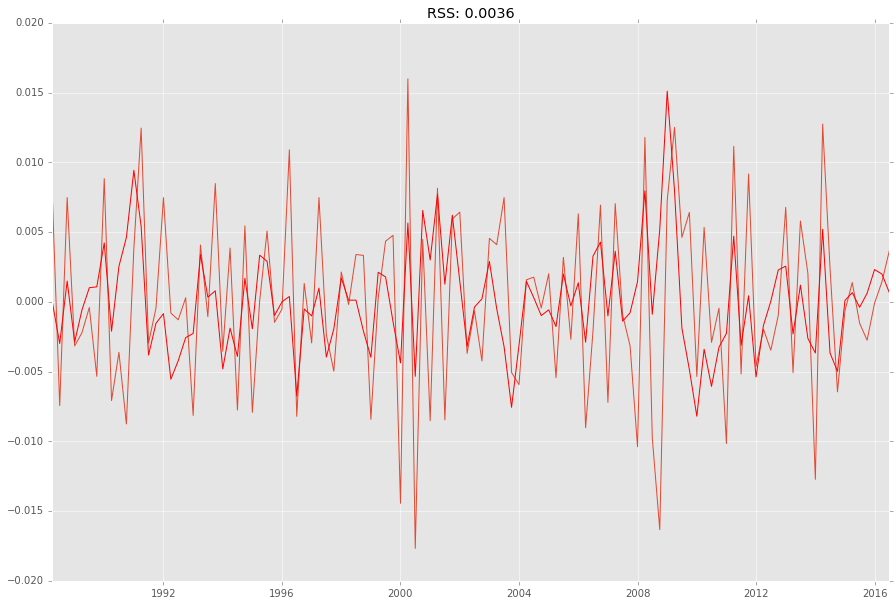

In [120]:
model = ARIMA(ts_diff, order=(0, 0, 2))  
results_MA = model.fit(exog=ex, disp=-1)


plt.plot(ts_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_diff)**2))

In [121]:
#Call predict on the model
df["rateMA"] = results_MA.predict()

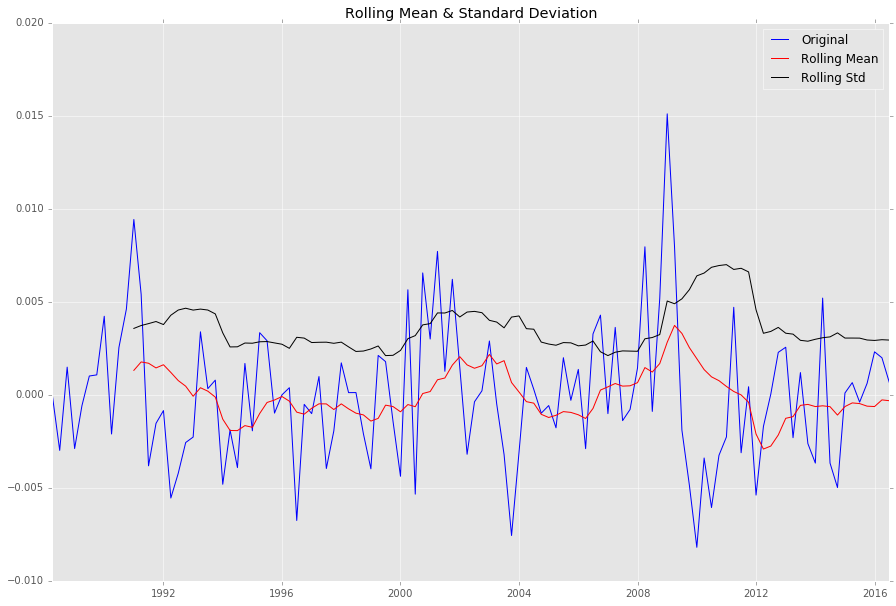

Test Statistic                -8.062352e+00
p-value                        1.630184e-12
# of Lags Used                 0.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (5%)           -2.887477e+00
Critical Value (1%)           -3.489590e+00
Critical Value (10%)          -2.580604e+00
dtype: float64

In [122]:
#Drop any NA values
df.rateMA.dropna(inplace=True)
adf(df.rateMA)

In [123]:
# Root Mean Squared Error (RMSE)
model_MA_RMSE = RMSE(df.rateMA, df.rate)
#model_MA_RMSE

In [124]:
#Populate into the dataframe
dfResults.loc[7,"Model"] = "MA(2) with sentiments"
dfResults.loc[7,"Forecast"] = df.rate.sub(df.rateMA).mean()
dfResults.loc[7,"RMSE"] = model_MA_RMSE
dfResults.loc[7,"AIC"] = results_MA.aic
dfResults.loc[7,"BIC"] = results_MA.bic
dfResults.loc[7,"ADF"] =  -7.743146e+00
dfResults.loc[7,"Durbin"] = sm.stats.durbin_watson(results_MA.resid)

dfResults

,Model,Forecast,RMSE,AIC,BIC,ADF,Durbin
0,Mean,0.00612483,0.00599073,NA,NA,NA,NA
1,Linear,[0.00692634334447],0.00583051,-852.914,-847.424,NA,1.25307
2,Baseline AR(1),0.00351589,0.00655506,-865.267,-857.032,NA,2.15719
3,Moving Average 12,0.0054909,0.00565895,NA,NA,-4.68909,NA
4,Exp Smoothing 12,0.00481839,0.0054583,NA,NA,-5.06463,NA
5,Decomposition,-1.19582e-05,0.00364006,NA,NA,-7.71544,NaN
6,AR(2) with sentiments,0.00614539,0.00933648,-841.569,-830.625,-6.53901,2.03833
7,MA(2) with sentiments,0.00612587,0.0100436,-849.451,-838.507,-7.74315,1.93598


## ARIMA Models

If we combine differencing with autoregression and a moving average model, we obtain a non-seasonal ARIMA model. The full model can be written as

Number of AR (Auto-Regressive) terms (p): 

Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation.

Number of Differences (d): These are the number of nonseasonal differences.

An importance concern here is how to determine the value of ‘p’ and ‘q’.

Autocorrelation Function (ACF): It is a measure of the correlation between the TS with a lagged version of itself.

Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons.

In [125]:
# For ACF and PACF plots
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_diff, nlags=20)

lag_acf

array([ 1.        , -0.43994675,  0.08344672, -0.14015099,  0.1000573 ,
       -0.12321628,  0.04482093, -0.01984729, -0.0774347 ,  0.0999292 ,
        0.10523417, -0.16086009,  0.0318418 , -0.0682841 ,  0.06667933,
       -0.0410772 ,  0.12694242, -0.1122967 , -0.04297672,  0.13323585,
       -0.04018557])

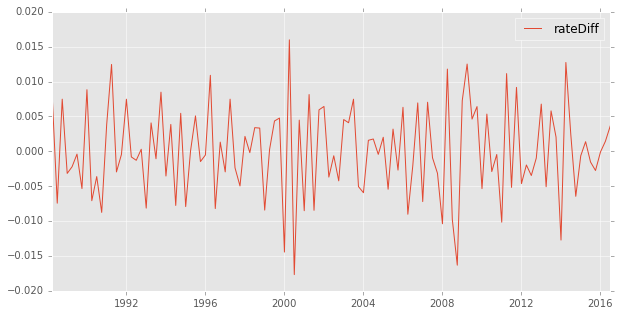

In [128]:
# df.plot(kind ="line", y=["rateDiff", "rate"])
plt.figure(figsize=(10,5))
plt.plot(df.index, df["rateDiff"])
plt.legend()
plt.show()

## Observation:
From above plot, we see that rate has some trend as the mean is not constant across the time interval.  However, the rateDiff seems to be stationary. 

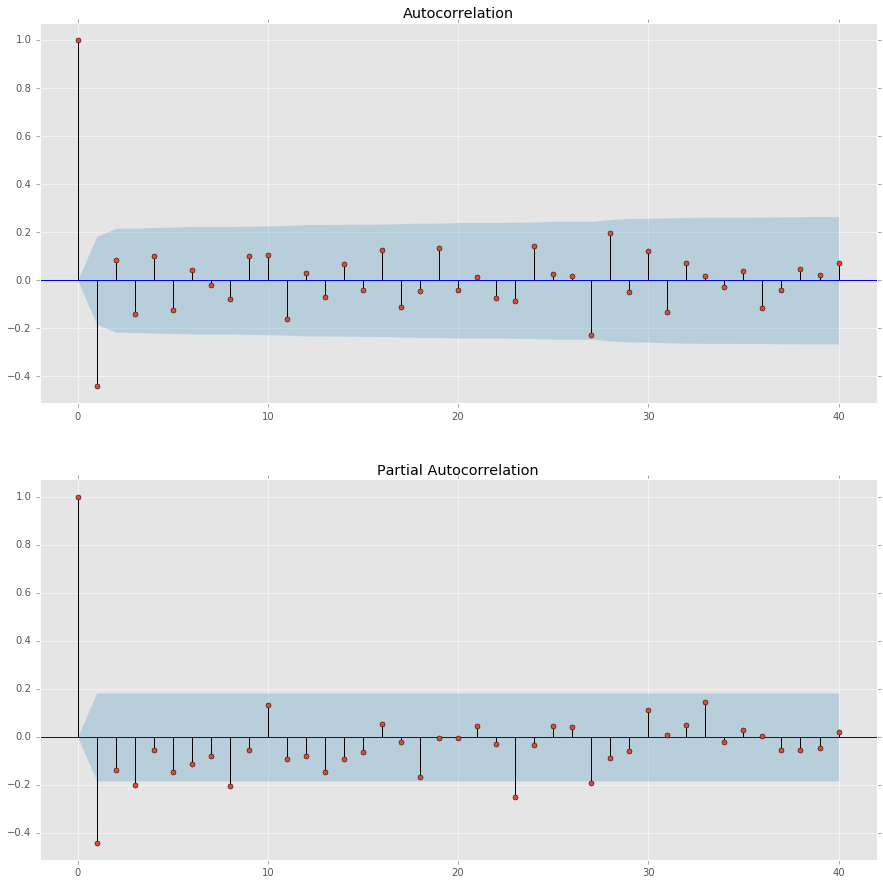

In [129]:
#Graphs for ACF and PACF

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(ts_diff.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_diff, lags=40, ax=ax2)

# Cross Validation

In [130]:
# A custom cross validation function
#  Inputs
#      results -- a dataframe containing the data
#      p -- AutoRegression parameter
#      d -- Differencing parameter
#      q -- Moving average parameter
#  Returns
#      Means value for 
#      MFE, MAE, RMSE, aic, bic, Durbin
#
def time_series_cv(result, p,d,q):
    step = 1
    start = 90
    sequence = range(start, len(result), step)
    
    aics = np.zeros(len(sequence))
    bics = np.zeros(len(sequence))
    MFEs = np.zeros(len(sequence))
    MAEs = np.zeros(len(sequence))
    Durbin = np.zeros(len(sequence))
   
    RMSEs = np.zeros(len(sequence))

    idx = 0

    for i in sequence:

        train = result[:i]
        test = result[i:i+1] 

        train_exog=np.column_stack((train.posDiff,train.negDiff))
        test_exog=np.column_stack((test.posDiff,test.negDiff))
        train_endog = train[['rateDiff']]
        test_endog = test[['rateDiff']]
        predictQ = test[['YearQuart']]
        
        model_AR1MA = ARIMA(train_endog, exog=train_exog, order=(p,d,q)).fit()
        predict_rate = model_AR1MA.predict(str(predictQ.YearQuart.values[0]), str(predictQ.YearQuart.values[0]), \
                                   exog=test_exog, dynamic=True)

        aics[idx] = model_AR1MA.aic
        bics[idx] = model_AR1MA.bic
        
        predicted_ratediffs = pd.Series(model_AR1MA.fittedvalues, copy=True)
        predicted_rates = predicted_ratediffs.cumsum()
        
        predicted_rate = predicted_rates[len(predicted_rates)-1] 
        MFEs[idx] = mean_forecast_err(test_endog, predicted_rate)
        MAEs[idx] = mean_absolute_err(test_endog, predicted_rate)
        RMSEs[idx] = root_mean_square_error(test_endog, predicted_rate)
        
        Durbin[idx] = sm.stats.durbin_watson(model_AR1MA.resid)
        
        idx = idx + 1
    return MFEs.mean(), MAEs.mean(), RMSEs.mean(), aics.mean(), bics.mean(), Durbin.mean()

In [131]:
#Function for mean forcast error
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

In [132]:
#Function for mean absolute error
def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat)) # or percent error = * 100

In [133]:
#Function for root mean sqaure error
# use the root mean square error to calculate error values
def root_mean_square_error(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

## Running the ARIMA Model

In [134]:
from statsmodels.tsa.arima_model import ARIMA

ts = df.rate
ts_diff=df.rateDiff
ts_diff.dropna(inplace = True)
ts_diff.head()

date
1988-04-01    0.007595
1988-07-01   -0.007439
1988-10-01    0.007474
1989-01-01   -0.003169
1989-04-01   -0.002216
Name: rateDiff, dtype: float64

In [135]:
# Running the ARIMA Model(1,0,1)
model_AR1MA = ARIMA(ts_diff, order=(1,0,1))
results_ARIMA = model_AR1MA.fit(exog=ex, disp = -1)
results_ARIMA.fittedvalues.head()

date
1988-04-01   -0.000040
1988-07-01   -0.002400
1988-10-01    0.000985
1989-01-01   -0.002422
1989-04-01   -0.000606
dtype: float64

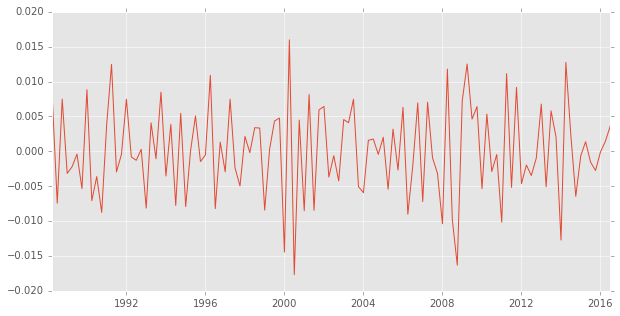

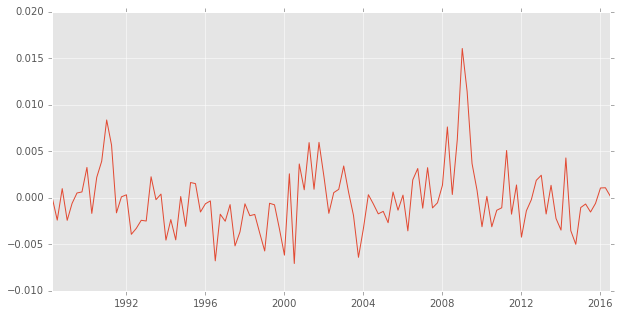

In [143]:
# print ts_diff.index.values
# ts_diff.plot()
# results_ARIMA.fittedvalues.plot()

plt.figure(figsize=(10,5))
plt.plot(ts_diff.index.values, ts_diff.values)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(results_ARIMA.fittedvalues.index.values, results_ARIMA.fittedvalues.values)
plt.legend()
plt.show()

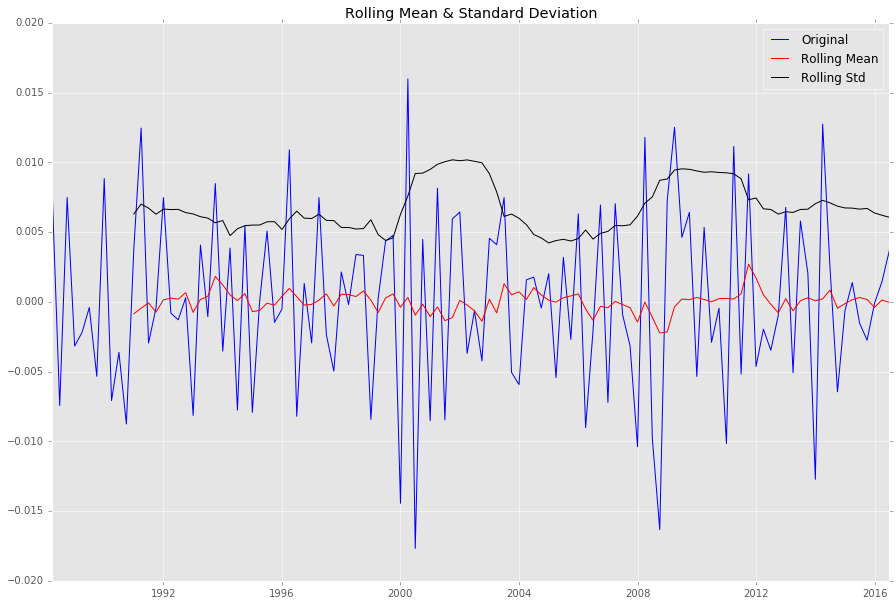

Test Statistic                -5.997242e+00
p-value                        1.690141e-07
# of Lags Used                 7.000000e+00
Number of Observations Used    1.060000e+02
Critical Value (5%)           -2.889217e+00
Critical Value (1%)           -3.493602e+00
Critical Value (10%)          -2.581533e+00
dtype: float64

In [144]:
adf(ts_diff)

In [92]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()


In [93]:
predictions_ARIMA_2 = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2 = predictions_ARIMA_2.add(predictions_ARIMA_diff_cumsum,fill_value=0)


In [94]:
#Put the predicted values on the dataframe
df['rateARIMA'] = predictions_ARIMA_2

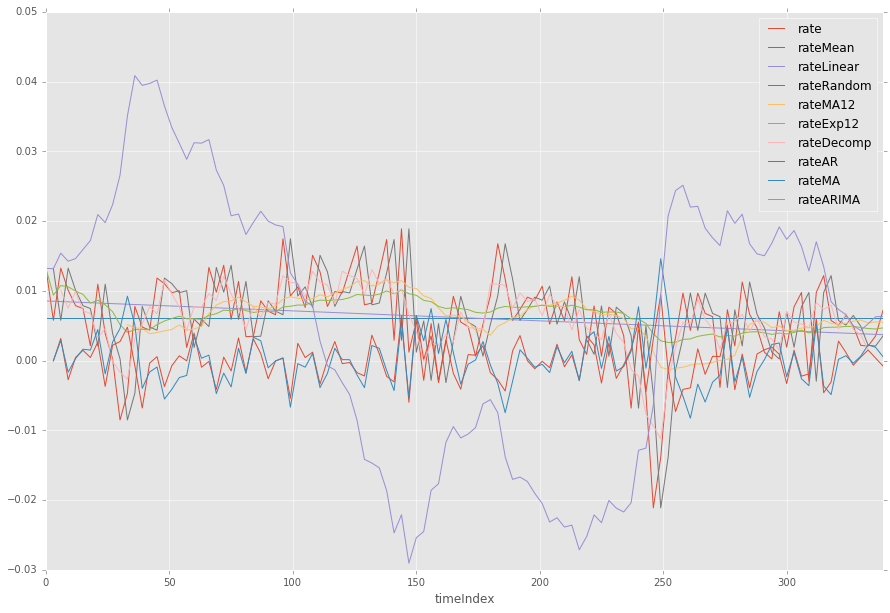

In [95]:
#Plotting all the models on a single graph

df.plot(kind="line", x="timeIndex", y = ["rate", "rateMean", "rateLinear", "rateRandom",
                                             "rateMA12", "rateExp12", "rateDecomp", "rateAR", "rateMA", "rateARIMA"])

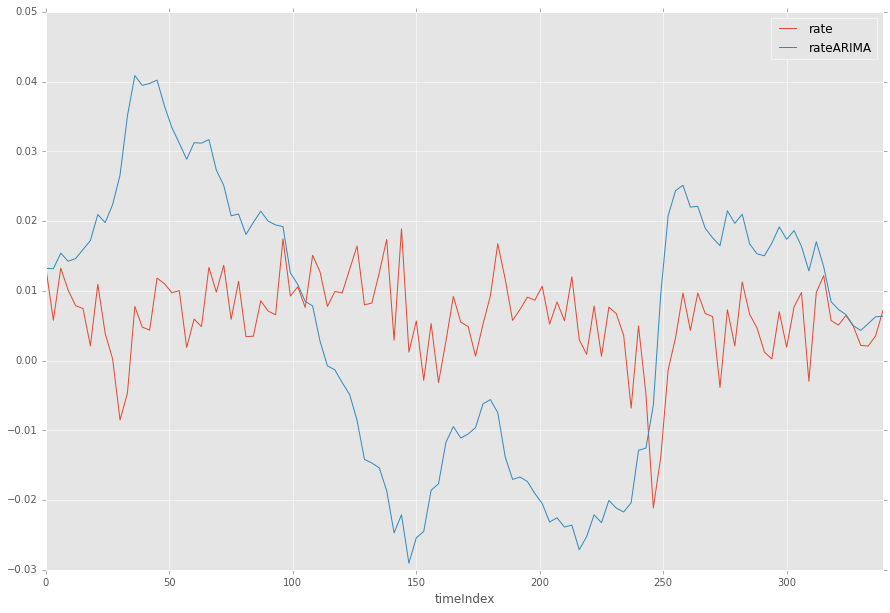

In [96]:
#Plotting just the rate and the ARIMA model arrived at earlier for (1, 0, 1)
df.plot(kind="line", x="timeIndex", y = ["rate", "rateARIMA"])

In [97]:
#Print few lines of the dataframe for visual inspection
df.head()

,date,rate,YearQuart,pos,neg,rateMean,timeIndex,rateLinear,rateShift1,posShift1,...,rateDiff,posDiff,negDiff,rateRandom,rateMA12,rateExp12,rateDecomp,rateAR,rateMA,rateARIMA
1988-06-30,1988-04-01,0.013215,1988q2,44.750,41.125,0.006129,0,0.008547,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.013215,NaN,NaN,NaN,0.013215
1988-09-30,1988-07-01,0.005775,1988q3,449.222,385.903,0.006129,3,0.008504,0.013215,44.750,...,-0.007439,404.472,344.778,0.013215,NaN,0.009388,NaN,-0.000048,-0.000034,0.013171
1988-12-31,1988-10-01,0.013250,1988q4,456.489,386.511,0.006129,6,0.008462,0.005775,449.222,...,0.007474,7.267,0.608,0.005775,NaN,0.010750,0.010057,0.003172,0.002848,0.015394
1989-03-31,1989-01-01,0.010080,1989q1,433.625,383.750,0.006129,9,0.008419,0.013250,456.489,...,-0.003169,-22.864,-2.761,0.013250,NaN,0.010568,0.007521,-0.002744,-0.001674,0.014242
1989-06-30,1989-04-01,0.007864,1989q2,432.750,381.375,0.006129,12,0.008376,0.010080,433.625,...,-0.002216,-0.875,-2.375,0.010080,NaN,0.009963,0.009905,0.000444,0.000302,0.014623


In [98]:
df.tail()

,date,rate,YearQuart,pos,neg,rateMean,timeIndex,rateLinear,rateShift1,posShift1,...,rateDiff,posDiff,negDiff,rateRandom,rateMA12,rateExp12,rateDecomp,rateAR,rateMA,rateARIMA
2015-09-30,2015-07-01,0.004928,2015q3,517.791,476.334,0.006129,327,0.003883,0.006466,576.958,...,-0.001538,-59.167,-45.583,0.006466,0.005649,0.004892,0.004443,-0.000674,-0.000366,0.004992
2015-12-31,2015-10-01,0.002176,2015q4,471.958,454.667,0.006129,330,0.003840,0.004928,517.791,...,-0.002753,-45.833,-21.667,0.004928,0.005812,0.004739,0.003689,0.000492,0.000621,0.004316
2016-03-31,2016-01-01,0.002080,2016q1,445.694,475.931,0.006129,333,0.003797,0.002176,471.958,...,-0.000096,-26.264,21.264,0.002176,0.005402,0.004590,0.001523,0.001507,0.002261,0.005282
2016-06-30,2016-04-01,0.003516,2016q2,444.416,479.584,0.006129,336,0.003754,0.002080,445.694,...,0.001436,-1.278,3.653,0.002080,0.005536,0.004529,NaN,0.000357,0.001901,0.006270
2016-09-30,2016-07-01,0.007176,2016q3,486.333,481.292,0.006129,339,0.003711,0.003516,444.416,...,0.003660,41.917,1.708,0.003516,0.005491,0.004678,NaN,-0.000778,0.000567,0.006357


In [99]:
#Drop the first row from dataframe as it contains NA for rateDiff
#df.dropna(inplace = True)
df = df[1:]

## Running a ARIMA for different combinations of p, d and q

In [100]:
# Running the ARIMA Model(2,0,2)
model_AR1MA_temp = ARIMA(ts_diff, order=(2,0,2))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA202'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 2,0,2)
dfResults.loc[9,"Model"] = "ARIMA202"
dfResults.loc[9,"Forecast"] = MFE
dfResults.loc[9,"RMSE"] = RMSE
dfResults.loc[9,"AIC"] = aic
dfResults.loc[9,"BIC"] = bic
dfResults.loc[9,"ADF"] = "RejectNull"
dfResults.loc[9,"Durbin"] = Durbin

In [101]:
# Running the ARIMA Model(3,0,2)
model_AR1MA_temp = ARIMA(ts_diff, order=(3,0,2))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA302'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 3,0,2)
dfResults.loc[10,"Model"] = "ARIMA302"
dfResults.loc[10,"Forecast"] = MFE
dfResults.loc[10,"RMSE"] = RMSE
dfResults.loc[10,"AIC"] = aic
dfResults.loc[10,"BIC"] = bic
dfResults.loc[10,"ADF"] = "RejectNull"
dfResults.loc[10,"Durbin"] = Durbin

In [102]:
# Running the ARIMA Model(4,0,2)
model_AR1MA_temp = ARIMA(ts_diff, order=(4,0,2))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA402'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 4,0,2)
dfResults.loc[11,"Model"] = "ARIMA402"
dfResults.loc[11,"Forecast"] = MFE
dfResults.loc[11,"RMSE"] = RMSE
dfResults.loc[11,"AIC"] = aic
dfResults.loc[11,"BIC"] = bic
dfResults.loc[11,"ADF"] = "RejectNull"
dfResults.loc[11,"Durbin"] = Durbin

In [103]:
# Running the ARIMA Model(6,0,2)
model_AR1MA_temp = ARIMA(ts_diff, order=(6,0,2))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA602'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 6,0,2)
dfResults.loc[13,"Model"] = "ARIMA602"
dfResults.loc[13,"Forecast"] = MFE
dfResults.loc[13,"RMSE"] = RMSE
dfResults.loc[13,"AIC"] = aic
dfResults.loc[13,"BIC"] = bic
dfResults.loc[13,"ADF"] = "RejectNull"
dfResults.loc[13,"Durbin"] = Durbin

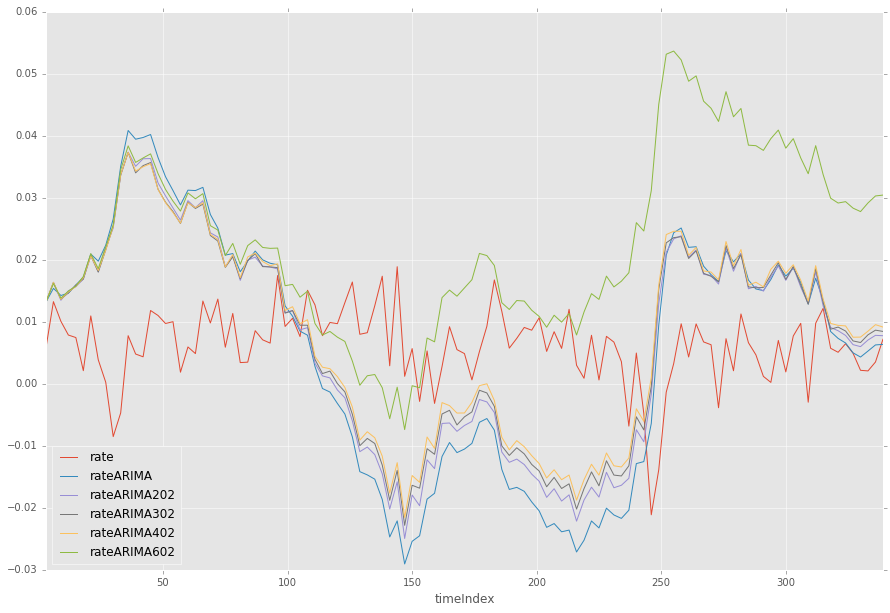

In [104]:
#Plot these models on a graph to visualize how it fits with the data

df.plot(kind="line", x="timeIndex", y = ["rate",  "rateARIMA",  "rateARIMA202",  "rateARIMA302",  
                                         "rateARIMA402",  "rateARIMA602"])

In [105]:
# Running some more models for different values of AR, but with 0 differencing and diffrent MA value

In [106]:
# Running the ARIMA Model(4,0,0)
model_AR1MA_temp = ARIMA(ts_diff, order=(4,0,0))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA400'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 4,0,0)
dfResults.loc[12,"Model"] = "ARIMA400"
dfResults.loc[12,"Forecast"] = MFE
dfResults.loc[12,"RMSE"] = RMSE
dfResults.loc[12,"AIC"] = aic
dfResults.loc[12,"BIC"] = bic
dfResults.loc[12,"ADF"] = "RejectNull"
dfResults.loc[12,"Durbin"] = Durbin

In [107]:
# Running the ARIMA Model(5,0,0)
model_AR1MA_temp = ARIMA(ts_diff, order=(5,0,0))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA500'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 5,0,0)
dfResults.loc[14,"Model"] = "ARIMA500"
dfResults.loc[14,"Forecast"] = MFE
dfResults.loc[14,"RMSE"] = RMSE
dfResults.loc[14,"AIC"] = aic
dfResults.loc[14,"BIC"] = bic
dfResults.loc[14,"ADF"] = "RejectNull"
dfResults.loc[14,"Durbin"] = Durbin

In [108]:
# Running the ARIMA Model(5,0,1)
model_AR1MA_temp = ARIMA(ts_diff, order=(5,0,1))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA501'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 5,0,1)
dfResults.loc[15,"Model"] = "ARIMA501"
dfResults.loc[15,"Forecast"] = MFE
dfResults.loc[15,"RMSE"] = RMSE
dfResults.loc[15,"AIC"] = aic
dfResults.loc[15,"BIC"] = bic
dfResults.loc[15,"ADF"] = "RejectNull"
dfResults.loc[15,"Durbin"] = Durbin

In [109]:
# Running the ARIMA Model(5,0,3)
model_AR1MA_temp = ARIMA(ts_diff, order=(5,0,3))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA503'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 5,0,3)
dfResults.loc[19,"Model"] = "ARIMA503"
dfResults.loc[19,"Forecast"] = MFE
dfResults.loc[19,"RMSE"] = RMSE
dfResults.loc[19,"AIC"] = aic
dfResults.loc[19,"BIC"] = bic
dfResults.loc[19,"ADF"] = "RejectNull"
dfResults.loc[19,"Durbin"] = Durbin

In [110]:
# Running the ARIMA Model(3,0,0)
model_AR1MA_temp = ARIMA(ts_diff, order=(3,0,0))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA300'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 3,0,0)
dfResults.loc[16,"Model"] = "ARIMA300"
dfResults.loc[16,"Forecast"] = MFE
dfResults.loc[16,"RMSE"] = RMSE
dfResults.loc[16,"AIC"] = aic
dfResults.loc[16,"BIC"] = bic
dfResults.loc[16,"ADF"] = "RejectNull"
dfResults.loc[16,"Durbin"] = Durbin

In [111]:
#Running the ARIMA Model(2,0,0)
model_AR1MA_temp = ARIMA(ts_diff, order=(2,0,0))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA200'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 2,0,0)
dfResults.loc[17,"Model"] = "ARIMA200"
dfResults.loc[17,"Forecast"] = MFE
dfResults.loc[17,"RMSE"] = RMSE
dfResults.loc[17,"AIC"] = aic
dfResults.loc[17,"BIC"] = bic
dfResults.loc[17,"ADF"] = "RejectNull"
dfResults.loc[17,"Durbin"] = Durbin

In [112]:
#Running the ARIMA Model(1,0,0)
model_AR1MA_temp = ARIMA(ts_diff, order=(1,0,0))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA100'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 1,0,0)
dfResults.loc[18,"Model"] = "ARIMA100"
dfResults.loc[18,"Forecast"] = MFE
dfResults.loc[18,"RMSE"] = RMSE
dfResults.loc[18,"AIC"] = aic
dfResults.loc[18,"BIC"] = bic
dfResults.loc[18,"ADF"] = "RejectNull"
dfResults.loc[18,"Durbin"] = Durbin

In [113]:
#Running the ARIMA Model(4,0,2)
model_AR1MA_temp = ARIMA(ts_diff, order=(4,0,2))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA402'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 4,0,2)
dfResults.loc[19,"Model"] = "ARIMA402"
dfResults.loc[19,"Forecast"] = MFE
dfResults.loc[19,"RMSE"] = RMSE
dfResults.loc[19,"AIC"] = aic
dfResults.loc[19,"BIC"] = bic
dfResults.loc[19,"ADF"] = "RejectNull"
dfResults.loc[19,"Durbin"] = Durbin

In [114]:
#Running the ARIMA Model(4,0,1)
model_AR1MA_temp = ARIMA(ts_diff, order=(4,0,1))
results_ARIMA_temp = model_AR1MA_temp.fit(exog=ex, disp = -1)

predictions_ARIMA_diff_temp = pd.Series(results_ARIMA_temp.fittedvalues, copy=True)

predictions_ARIMA_diff_cumsum_temp = predictions_ARIMA_diff_temp.cumsum()


predictions_ARIMA_2_temp = pd.Series(ts.ix[0], index=ts.index)
predictions_ARIMA_2_temp = predictions_ARIMA_2_temp.add(predictions_ARIMA_diff_cumsum_temp,fill_value=0)

df['rateARIMA401'] = predictions_ARIMA_2_temp
MFE, MAE, RMSE, aic, bic, Durbin = time_series_cv(df, 4,0,1)
dfResults.loc[20,"Model"] = "ARIMA401"
dfResults.loc[20,"Forecast"] = MFE
dfResults.loc[20,"RMSE"] = RMSE
dfResults.loc[20,"AIC"] = aic
dfResults.loc[20,"BIC"] = bic
dfResults.loc[20,"ADF"] = "RejectNull"
dfResults.loc[20,"Durbin"] = Durbin

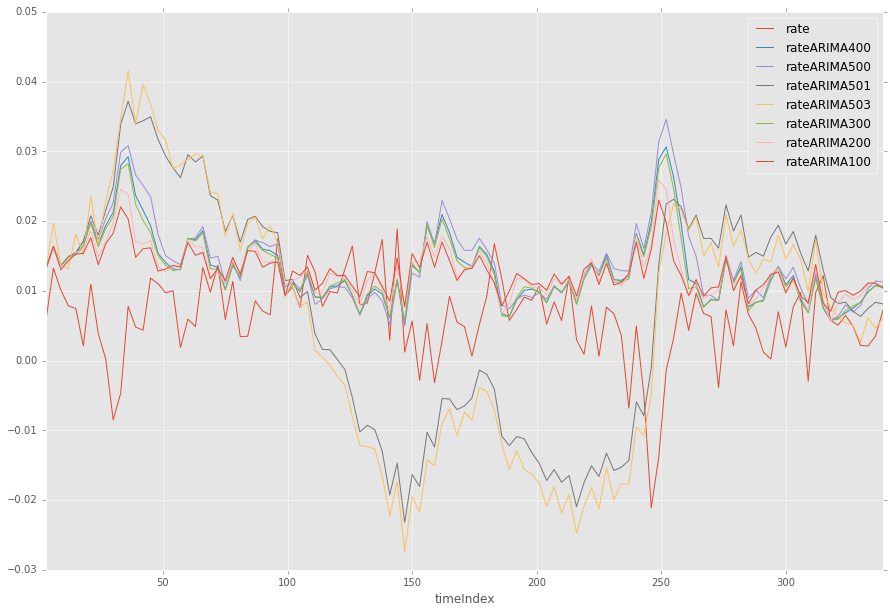

In [115]:
#Plot the different ARIMA models on the graph

df.plot(kind="line", x="timeIndex", y = ["rate",   "rateARIMA400", "rateARIMA500", "rateARIMA501",
                                        "rateARIMA503", "rateARIMA300", "rateARIMA200", "rateARIMA100" ])

ARIMA (2, 0, 0), ARIMA(1, 0, 0)  appears to be better fitting the data in the above graph.
So, plotting these again in a separate graph along with other models.

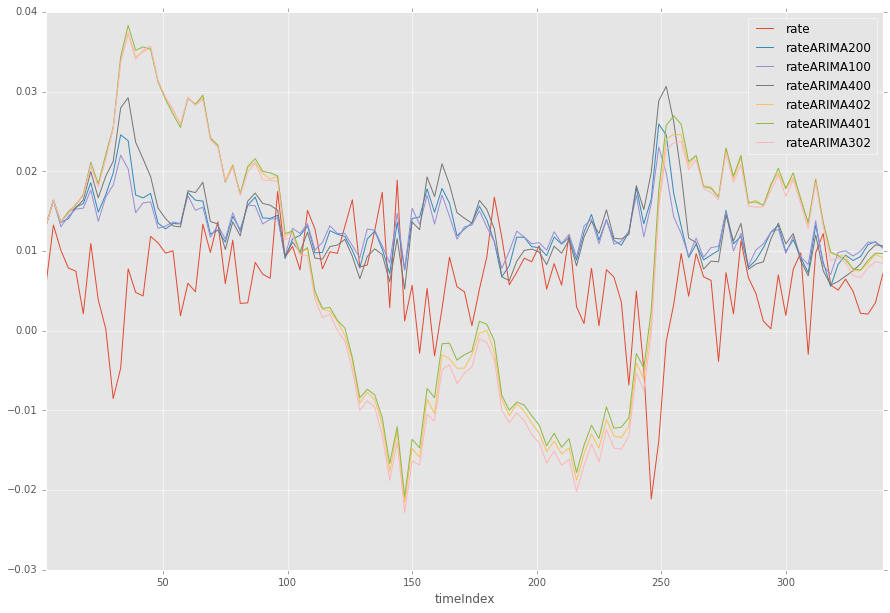

In [116]:
## Plot the model on the graph
df.plot(kind="line", x="timeIndex", y = ["rate",  "rateARIMA200",  "rateARIMA100", "rateARIMA400",
                                         "rateARIMA402",  "rateARIMA401", "rateARIMA302" ])

In [117]:
#For ARIMA (1,0,1)
model_ARIMA_RMSE = root_mean_square_error(df.rateARIMA, df.rate)
model_ARIMA_RMSE

0.020095745166068355

In [118]:
#Put the values of the base ARIMA model (1, 0, 1) in the dataframe
df['rateARIMA101'] = predictions_ARIMA_2
dfResults.loc[8,"Model"] = "ARIMA101"
dfResults.loc[8,"Forecast"] = df.rate.sub(predictions_ARIMA_2).mean()
dfResults.loc[8,"RMSE"] = model_ARIMA_RMSE
dfResults.loc[8,"AIC"] = results_ARIMA.aic
dfResults.loc[8,"BIC"] = results_ARIMA.bic
dfResults.loc[8,"ADF"] = -6.094205e+00
dfResults.loc[8,"Durbin"] = sm.stats.durbin_watson(results_ARIMA.resid)

In [119]:
#Displaying the results of all the models ffrom the results dataframe
dfResults

,Model,Forecast,RMSE,AIC,BIC,ADF,Durbin
0,Mean,0.00612926,0.00601676,NA,NA,NA,NA
1,Linear,[0.00693521052642],0.00584964,-844.715,-839.243,NA,1.24086
2,Baseline AR(1),0.00351589,0.00654511,-857.077,-848.868,NA,2.1543
3,Moving Average 12,0.0054909,0.00550371,NA,NA,-4.68909,NA
4,Exp Smoothing 12,0.00481832,0.0054752,NA,NA,-5.06463,NA
5,Decomposition,2.75858e-05,0.00363306,NA,NA,-7.71544,NaN
6,AR(2) with sentiments,0.00609168,0.00928314,-833.843,-822.934,-6.53901,2.04204
7,MA(2) with sentiments,0.00602457,0.00991768,-841.408,-830.499,-7.74315,1.93423
9,ARIMA202,-0.000346063,0.00680533,-744.054,-723.15,RejectNull,2.02152
10,ARIMA302,0.00445305,0.00818253,-738.614,-715.098,RejectNull,2.04355



From the above table, we see model ARIMA101, ARIMA202 and ARIMA602 are doing good. Plotting these again. 

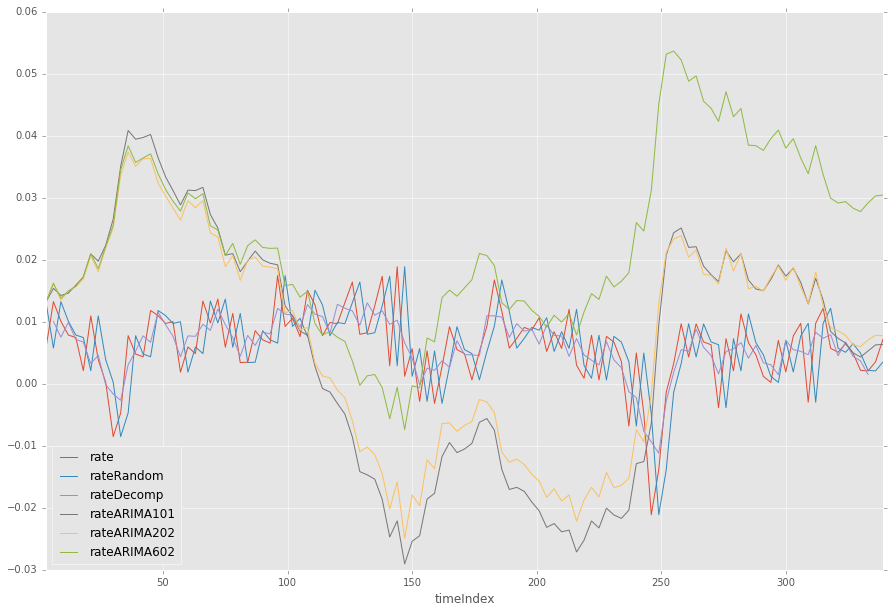

In [120]:
## Plot the model on the graph
df.plot(kind="line", x="timeIndex", y = ["rate", "rateRandom", "rateDecomp", "rateARIMA101", 
                                         "rateARIMA202", "rateARIMA602"])

## Observation
Our final dataframe of results shows that we we have three models that are best performing compared the the rest. These are the ARIMA101, ARIMA202 and ARIMA602. IF we want to minimize AIC and BIC the most than we would choose the ARIMA101 or if you want to have the least amount of autocorrelation then we would choose either of the other two models. 

In terms of forecast error and RMSE, the values are very close to zero for all three models. The final choice would still be the ARIMA101 because since the ACF and PACF chose the p and q lags as 1 for optimal parameters.

## Prediction using Model

In [124]:
#Create a dataframe to hold the new articles by date
NYTCorpus_predict = pd.DataFrame({'day' : [], 'text' : []})
#NYTCorpus

#Load data from all the files
root = "DataPredict"
filenumber = 0
for filename in os.listdir(root):
    date = filename.split(".")[0]
    NYTCorpus_predict.ix[filenumber,0] =date
    with open(os.path.join(root, filename), 'r') as myfile:
        data = myfile.read().replace('\n', ' ')
    NYTCorpus_predict.ix[filenumber,1] =data
    filenumber = filenumber + 1

print NYTCorpus_predict.shape

NYTCorpus_predict.head()

(74, 2)


,day,text
0,,   Bud1            %                      ...
1,20161001,British companies expect a surge in output in ...
2,20161002,Asian shares got the new quarter off to a firm...
3,20161003,Road fatalities are the leading cause of death...
4,20161004,Japanese insurer Sompo Holdings Inc will annou...


In [159]:
### Merge all the daily data to a quarter corpus

In [160]:
NYTCorpus_predict = NYTCorpus_predict.drop(NYTCorpus_predict.index[[0]])
NYTCorpus_predict['quarter'] = NYTCorpus_predict['day'].apply(get_quarter_from_date)
NYTCorpus_predict_byQuarter = NYTCorpus_predict.groupby(['quarter'])['text'].apply(lambda x: ' '.join(x)).reset_index()
print NYTCorpus_predict_byQuarter.shape
NYTCorpus_predict_byQuarter.head()

(1, 2)


,quarter,text
0,2016q4,Asian shares got the new quarter off to a firm...


In [ ]:
# Get the sentiment score for the quarter
current_pos, current_neg = get_sentiment_score(NYTCorpus_predict_byQuarter['text'][0].decode('utf-8'))

In [157]:
# Get the 2016 Q3 data
df_2016_Q3 = df.ix[112,1:].copy() 
df_2016_Q3.head()

rate         0.00717598
YearQuart        2016q3
pos             486.333
neg             481.292
rateMean     0.00612926
Name: 2016-09-30 00:00:00, dtype: object

In [161]:
# Get the positive and negative sentiment score difference from the previous quarter
current_pos_diff = current_pos - df_2016_Q3.pos
current_neg_diff = current_neg - df_2016_Q3.neg

In [163]:
# Endogenous variable for fit
endog = df.rateDiff 
# Exogenous variable for fit
exog = np.column_stack((df.posDiff, df.negDiff))
predict_exog = np.column_stack((current_pos_diff, current_neg_diff))

In [164]:
# Run the ARIMA 1,0,1 model
model_AR1MA = ARIMA(endog=endog, exog=exog, order=(1,0,1)).fit()
# Predict the rate Diff for 2016Q4
predict_rateDiff = model_AR1MA.predict('2016Q4', '2016Q4', exog=predict_exog, dynamic=True)

In [165]:
# Predict the rate for 2016Q4
predict_rate = df_2016_Q3.rate + predict_rateDiff
print predict_rate

2016-12-31    0.005134
Freq: Q-DEC, dtype: float64


In [166]:
#Predict the GDP in billions of chained 2009 dollars for 2016Q4
predict_GDP = gdp_data.ix[277,1:]['GDP in billions of chained 2009 dollars'] + \
              gdp_data.ix[277,1:]['GDP in billions of chained 2009 dollars']*predict_rate[0]

In [168]:
print "Predicted GDP in billions of 2009 dollars for 2016 Q4 is : ", predict_GDP

Predicted GDP in billions of 2009 dollars for 2016 Q4 is :  16668.2351785
